In [1]:
from bs4 import BeautifulSoup
import requests
import re
import seaborn as sns
import pandas as pd
import numpy as np
import os
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import json
import urllib.request
from sklearn.metrics import r2_score
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
# from sklearn.model_selection import TimeSeriesSplit

In [2]:
# class YoutubeChannel():
#     def __init__(self,ChannelUrl):
#         self.dailySubscribers = allData[["Date","DailySubscribers"]]
#         self.totalSubscribers = allData[["Date","TotalSubscribers"]]
#         self.dailyVideoViews = allData[["Date","DailyVideoViews"]]
#         self.totalVideoViews = allData[["Date","TotalVideoViews"]]
#         self.allData = getAllCharts()

In [3]:
links = ["https://web.archive.org/web/20190524171902/https://socialblade.com/youtube/user/mmoshaya/monthly",
        "https://web.archive.org/web/20190524075036/https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
         "https://web.archive.org/web/20190830014628/https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
        "https://web.archive.org/web/20190524134324/https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
        "https://web.archive.org/web/20190525094206/https://socialblade.com/youtube/user/banderitax/monthly",
        "https://web.archive.org/web/20190830022605/https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [4]:
new_links = ["https://socialblade.com/youtube/user/mmoshaya/monthly",
            "https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
            "https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
            "https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
            "https://socialblade.com/youtube/user/banderitax/monthly",
            "https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [5]:
# save req to html file if not found
for i in range(len(links)):
    if f"req{i}.html" not in os.listdir('.'):
        open("req"+str(i)+".html","w",encoding="UTF-8").write(requests.get(links[i]).text)

In [6]:
# save new req to html file if not found
for i in range(len(new_links)):
    if f"new_req{i}.html" not in os.listdir('.'):
        opener = urllib.request.build_opener()
        opener.addheaders = [('User-agent', 'Mozilla/5.0')]
        response = str(opener.open(new_links[i]).read())
        open("new_req"+str(i)+".html","w").write(response)

In [7]:
# read files from  disk - files name: req0.html .... req4.html
resText = [open("req"+str(i)+".html","r",encoding="UTF-8").read() for i in range(len(links))]
# read files from  disk - files name: new_req0.html .... new_req4.html
new_resText = [open("new_req"+str(i)+".html","r").read() for i in range(len(new_links))]

In [8]:
def getChartData(soup,chart_name):
    ds_element = soup.find("div",{"id":chart_name}).next_element.next_element.text
    regex = "[0-9]+-[0-9]+-[0-9]+,[0-9]+"
    dailySub = [i.split(",") for i in re.findall(regex,ds_element)]
    Date = pd.Series([i[0] for i in dailySub])
    count = pd.Series([i[1] for i in dailySub])
    return pd.DataFrame({
        "Date":Date.astype(np.datetime64),
        chart_name:count.astype(np.int64)
        })

In [9]:
def getDailySubscribers(soup):
    '''
    return dataframe contains date and dailySubscribers for the given soup
    '''
    return getChartData(soup,"DailySubscribers")

In [10]:
def getTotalSubscribers(soup):
    '''
    return dataframe contains date and totalSubscribers for the given soup
    '''
    return getChartData(soup,"TotalSubscribers")

In [11]:
def getDailyVideoViews(soup):
    '''
    return dataframe contains date and dailyVideoViews for the given soup
    '''
    return getChartData(soup,"DailyVideoViews")

In [12]:
def getTotalVideoViews(soup):
    '''
    return dataframe contains date and totalVideoViews for the given soup
    '''
    return getChartData(soup,"TotalVideoViews")

In [13]:
def getAllCharts(soup):
    '''
    return dataframe contains date, dailySubscribers, totalSubscribers, dailyVideoViews and totalVideoViews for the given soup
    '''
    ds = getDailySubscribers(soup)
    ts = getTotalSubscribers(soup)
    dv = getDailyVideoViews(soup)
    tv = getTotalVideoViews(soup)
    return ds.merge(ts,on="Date").merge(dv,on="Date").merge(tv,on="Date")

In [14]:
def getAllCharts_newlinks(response):
    allCharts = [json.loads(l[0]) for l in re.findall('(\[(\[\d+,-?\d+\],?)+\])',response)]
    col = re.findall('title: { text: \\\\\'([\w|\s]+) for',response)
    date1 = pd.Series([i[0] for i in allCharts[0]])
    weeklyGainedSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date1,unit="ms"),#.dt.date, #parse Date from timestamp to date
        col[0]: [i[1] for i in allCharts[0]],
        col[1]: [i[1] for i in allCharts[1]],
    })

    date2 = pd.Series([i[0] for i in allCharts[2]])
    monthlyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date2,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in allCharts[2]],
        "TotalVideoViews": [i[1] for i in allCharts[3]],
    })

    date3 = pd.Series([i[0] for i in allCharts[4]])
    weeklyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date3,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in allCharts[4]],
        "TotalVideoViews": [i[1] for i in allCharts[5]],
    })
    return [weeklyGainedSubsAndViews,monthlyTotoalSubsAndViews,weeklyTotoalSubsAndViews]

In [15]:
def concatOldDataWithNew(old_df,new_df):
    concated = pd.concat([old_df[["Date","TotalSubscribers","TotalVideoViews"]],new_df[1],new_df[2]])
    return concated.sort_values(by="Date",ignore_index=True) # sort by date and reset index

In [16]:
soups = [BeautifulSoup(r,"html5lib") for r in resText]

In [17]:
channels_df = [getAllCharts(soup) for soup in soups]

In [18]:
new_channels_df = [getAllCharts_newlinks(r) for r in new_resText]

In [19]:
top1_df = concatOldDataWithNew(channels_df[0], new_channels_df[0]) # top 1 channel df
top2_df = concatOldDataWithNew(channels_df[1], new_channels_df[1]) # top 2 channel df
top3_df = concatOldDataWithNew(channels_df[2], new_channels_df[2]) # top 3 channel df
# top4_df = concatOldDataWithNew(channels_df[3], new_channels_df[3]) # top 4 channel df شلناها لان عدد الروز قليل
top4_df = concatOldDataWithNew(channels_df[4], new_channels_df[4]) # top 4 channel df
top5_df = concatOldDataWithNew(channels_df[5], new_channels_df[5]) # top 4 channel df

In [20]:
top1_df

,Date,TotalSubscribers,TotalVideoViews
0,2016-05-26 00:00:00,576989,157540838
1,2016-05-27 00:00:00,579557,157540838
2,2016-05-28 00:00:00,583261,160354910
3,2016-05-29 00:00:00,586661,160354910
4,2016-05-30 00:00:00,589832,162164368
...,...,...,...
1167,2021-08-26 04:00:00,20700000,14354629988
1168,2021-09-03 04:00:00,20800000,14409676120
1169,2021-09-11 04:00:00,20800000,14464951127
1170,2021-09-19 04:00:00,20800000,14516815312


In [21]:
# top1_df = channels_df[0] # top 1 channel df
# top2_df = channels_df[1] # top 2 channel df
# top3_df = channels_df[2] # top 3 channel df
# # top4_df = channels_df[3] # top 4 channel df شلناها لان عدد الروز قليل
# top4_df = channels_df[4] # top 4 channel df
# top5_df = channels_df[5] # top 4 channel df

In [22]:
# X_y = top1_df[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
# X_y.columns = ["ds","y"]
# m = Prophet(daily_seasonality=True)
# m.fit(X_y)

In [23]:
# future = m.make_future_dataframe(periods=365)

In [24]:
# forecast = m.predict(future)

In [25]:
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [26]:
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [27]:
#  m.plot_components(forecast)

In [28]:
# sns.pairplot(top1_df)

In [29]:
# total number of rows
# total = 0
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     total += len(c)
# print(f"the total number of rows is {total}")

In [30]:
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     print(c.info())

In [31]:
# nonZero = channels_df[0][channels_df[0].DailyVideoViews != 0]

In [32]:
# nonZero.join(nonZero.Date.dt.isocalendar()).groupby(["year","week"]).day.count().value_counts()

In [33]:
# channels_df[0].join(channels_df[0].Date.dt.isocalendar()).groupby(["year","week"]).day.count().value_counts()

In [34]:
# iso = channels_df[0].join(channels_df[0].Date.dt.isocalendar())
# # iso.where(iso.day == 1).first_valid_index()
# s = iso[iso.day ==1].iloc[0].name
# e = iso[iso.day ==7].iloc[-1].name


In [35]:
# iso.iloc[s:e+1].groupby(["year","week"]).day.count().value_counts()

In [36]:
# (new_channels_df[0][0].Date.dt.isocalendar().day == 1).value_counts()

In [37]:
ys_yhats = []
for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
    X_y = c[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
    X_y.columns = ["ds","y"]
    md = Prophet()
    md.fit(X_y.drop_duplicates(subset="y"))
            ############# Training #############
    future = md.make_future_dataframe(0)
    forecast = md.predict(future)
    ys_yhats.append(X_y.merge(forecast[["ds","yhat"]],on="ds"))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
df_cv = []
for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
    X_y = c[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
    X_y.columns = ["ds","y"]
    md = Prophet()
    md.fit(X_y.drop_duplicates(subset="y"))
        ############ Validation #############
    df_cv.append(cross_validation(md,horizon = '170 days'))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 15 forecasts with cutoffs between 2018-01-05 04:00:00 and 2021-04-09 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Making 15 forecasts with cutoffs between 2017-12-29 04:00:00 and 2021-04-02 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Making 14 forecasts with cutoffs between 2018-03-16 04:00:00 and 2021-03-25 04:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 15 forecasts with cutoffs between 2017-12-21 04:00:00 and 2021-03-25 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 14 forecasts with cutoffs between 2018-03-31 04:00:00 and 2021-04-09 04:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

## Validation Plots

In [39]:
df_cv[2]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-03-17 00:00:00,2.400014e+06,2.392801e+06,2.407245e+06,2399518,2018-03-16 04:00:00
1,2018-03-18 00:00:00,2.407269e+06,2.399994e+06,2.414482e+06,2406563,2018-03-16 04:00:00
2,2018-03-19 00:00:00,2.414422e+06,2.406804e+06,2.421857e+06,2413232,2018-03-16 04:00:00
3,2018-03-20 00:00:00,2.421790e+06,2.414754e+06,2.428975e+06,2419393,2018-03-16 04:00:00
4,2018-03-21 00:00:00,2.429380e+06,2.421985e+06,2.437045e+06,2427013,2018-03-16 04:00:00
...,...,...,...,...,...,...
997,2021-04-04 04:00:00,1.401873e+07,1.395653e+07,1.407416e+07,13800000,2021-03-25 04:00:00
998,2021-05-01 04:00:00,1.441380e+07,1.424510e+07,1.457212e+07,13900000,2021-03-25 04:00:00
999,2021-06-15 04:00:00,1.500457e+07,1.454248e+07,1.541280e+07,14000000,2021-03-25 04:00:00
1000,2021-07-25 04:00:00,1.544295e+07,1.468046e+07,1.614737e+07,14100000,2021-03-25 04:00:00


0.9805978181459879
0.991853615621367
0.9764454509645099
0.9809962252745004
0.9795552765174712


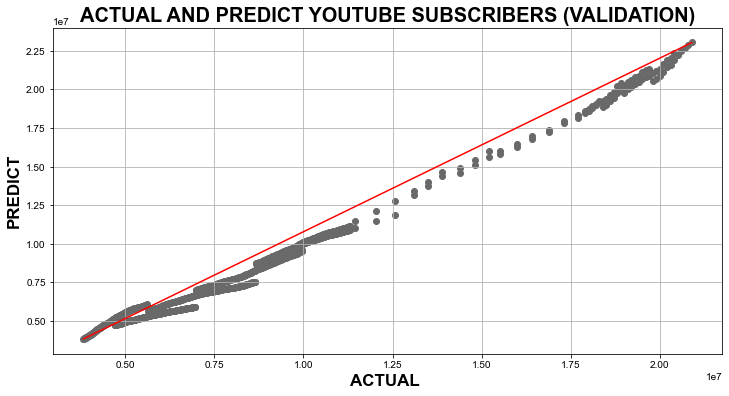

<Figure size 432x288 with 0 Axes>

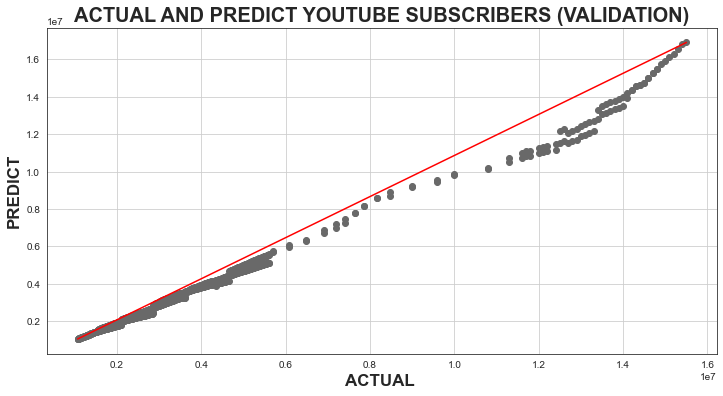

<Figure size 432x288 with 0 Axes>

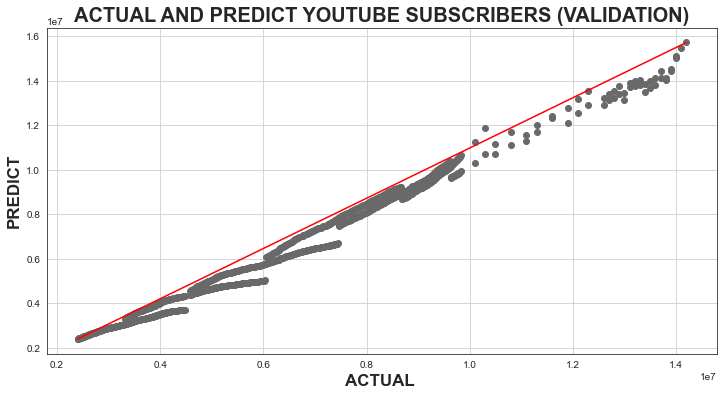

<Figure size 432x288 with 0 Axes>

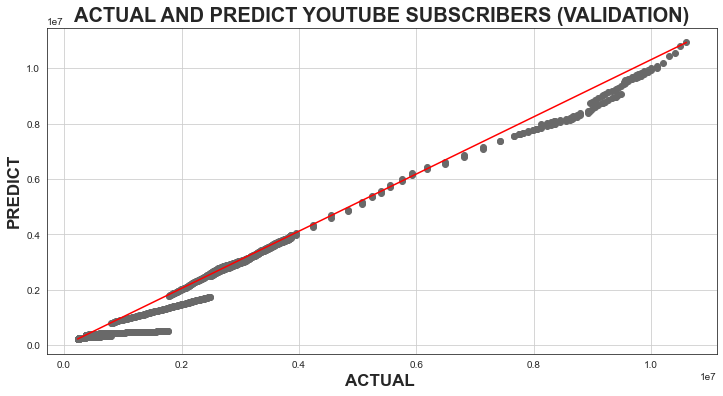

<Figure size 432x288 with 0 Axes>

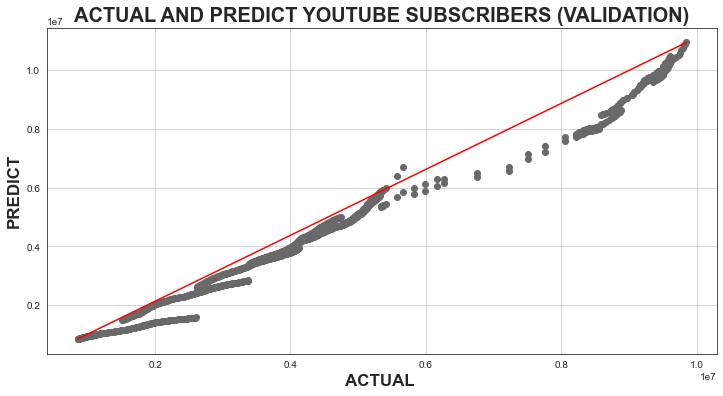

<Figure size 432x288 with 0 Axes>

In [40]:
for df in df_cv:
    plt.figure(figsize = [12,6])
    plt.scatter(df.y,df.yhat,color="dimgray")
    sns.set_style("white")

    x_plt_range = [df.y.min(),df.y.max()]
    y_plt_range = [df.yhat.min(),df.yhat.max()]
    plt.grid()
#     plt.xticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 
#     7000000, 8000000, 9000000, 10000000],
#     ["1M", "2M", "3M", "4M", "5M", "6M", 
#     "7M", "8M", "9M", "10M"])
#     plt.yticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 
#     7000000, 8000000, 9000000, 10000000,11000000],
#     ["1M", "2M", "3M", "4M", "5M", "6M", 
#     "7M", "8M", "9M", "10M","11M"])
    plt.title("ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS (VALIDATION)",fontsize = 20, weight = 'bold')
    plt.xlabel("ACTUAL ",fontsize = 17, weight = 'bold')
    plt.ylabel('PREDICT',fontsize = 17, weight = 'bold')
    plt.plot(x_plt_range,y_plt_range,c="r")
    
    plt.figure()
    




    #plt.grid()
#     sns.set_style("white")
#     plt.xlabel("ACTUAL ",fontsize = 17, weight = 'bold')
#     plt.ylabel('PREDICT',fontsize = 17, weight = 'bold')
#     plt.title("ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS FOR TOP 4th CHANNEL(VALIDATION)",fontsize = 20, weight = 'bold')
    
    print(r2_score(df.y,df.yhat))
    
    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtkAAAGMCAYAAAAP5r5HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAABqEklEQVR4nO3dd3iUVdrH8e+dhBqwRBHEhhV7AxEVFCy7uqvoquiKqNhYy6q77toQXXcBe8OCCqgoGlB01djdVaNY8wq6KiqKSrGgQkQklJDkvH+cZ8iTYWoyM2m/z3XNlZmnnjmZeeaeM/c5x5xziIiIiIhI5uQ1dgFERERERFoaBdkiIiIiIhmmIFtEREREJMMUZIuIiIiIZJiCbBERERGRDFOQLSIiIiKSac453TJ8AyYCLrh9nOI+nYBLgXeBn4FVwNfA/cCuUdtOCh0/2a002Oeq0LJhccoQWT83QTk3A6pD2x6bYNuk50yzXut77hvjbFMa6/nGqccq4BfgfWAksE4a5Y53vIrgf3wn0C3F/3ENsAKYC0yL8drokcZr46oYdRF9rmXA58DdwFYxntuwWMcLrc8DTgReAH4EKoEfgKeBIxIcK+ktTl3vFXqNVEfXT2i7t0LHujpqXTvgXODloKyVwE/Aq8CfgXbp1kOwzdzosqfzfAneQ7GOk0pZEtRv5DU1H5gK7JCo7ElupSm+JzYHbgdm498HK4Cv8K/73RK8Vx3QI8b6AaH1k+Isj37OK4HvgGeAfeKUsxC4HHgPf12uBL4P9jkyyXPcGZgAfBk8v6XBcUYQ4/qRoI6rgV+BT4M665LgWjcsheOtBpYEZfkrkNeA9+GAFF7L1fhr54fAaKBTjOduwEnAf/DXidVAOfAGcAHQNtXrbXC8wcG5JwMnhMryboJ9zg5tNyVqXb+o59Q7wXEmxaqfdLePU5dpfw6RJB4hC/EE0Bkfz7yFv3ZWAguB54CTgfwk163HktVVaNk/g2V/S+c1kqtboxegpd2ADsGbIPzC7JNkn92ABQle2KuB4aHtM/6mCLaJrJ+boKyXRx3/uQTbJj1nmnVb33OvBnaMsU1prOebYr1+DGycYrlTOd4XhD480/gfryB0wSezQXb0bQmwf9RzGxbreMG6IuC1JMecBFiMYyW9Jajvu0Pb/SfG+mNC6+cBHUPrNgM+SuF/tX2q9RDaZm502dN5vmQvyI6+LQV2ilf2JLfSFN4PffFf3uIdoxI4Ls571ZGZIDvWOQ+KOuaGwGdJ9hsb5zleTN0Ggejbl8A29azjL4D1kl1n0zjefQleP8luA+rxWn4TaBPaLw94NMk+bwGFKV5vC6n9PN03eFwROtbmcfZ7MbTNUVHrJkSVZ1yC80+KVT/pbp9iXSb8HCKFeIQMxxPALiSOZxxQFl3uGK+7QxLVVWjZpvgvH0sT1UVj3QqQTPsDsE7UslPxL6q1mFl34L/4Czr4Fr9pwf2jgCOAAmCcmX3snHsLuA14MnSYA4HzgvuP4FujIhbV50kkcHLU49+YWXfn3HcZPk8mz10A3IGvp3T8BAzHt7K0wwewZwBbAzsBD6d5zMjxCI7XE7gQWBfYBv/N/28x9rsCfzElKMs6+P93L6A9cH2ccszCt3bE81mc5X/Ctya1ATYCjgP2D8o5zcx2ds79lOC4mFk+/jXaP1SWCfg62BdfD22AU4BPgufwCv79E7ERcE+KzyVsBD6Q3hA42MwOd849E5SrDXBNaNsLnHPLg3Wd8O+/HYN184Lzfwl0x38I7Ib/X71sZns4535MsUzx/CHq8Wj8awtq/w8RMxt4rrDwdSIPH4gMw7+OOgNj8NefWKLLHJbwemNmecADwflq8L/UvY5/XR8OHIt/XUwws5ecc0uSPpPUvYq/dhKcrwP+uUTOeROwe2j7a/HvUfCvzUfwLcq98b9otAXON7MnnXOvhp7jcOC64OFyYBwwAx8M/BnYAtgK+LeZ7emcq4pR1nAd5wGb4F//G+Fff+cD/0rjuUeOZ0B+8LxGAB2BU83sNufcBzH2i/48ifZxjGXh6xzB+bbBX8cK8e//E4AHg/VD8C3P4H81Gw98A2yJb8XuBuyD/+LyjwRliTgLX9cfBZ+XmNmzoXMcDdwa3sHM1gUGBg9/AZ4PresQ2jfiBDO70Dm3MoXyNFRDPodSiUcyFk8E8cxL+P8Z+NfH/dT+P4fjX/t7AS+a2d7OuRVxDne7me3qnKtMdE7n3DfB/3cQ/j1ybqLtc66xo/yWdqP22/Bq/Aekw7cAdoiz/WRqv7ndEGP9LaH1JXGOMSy0zVVxtrmKON88Q9tE1s+Ns36f0Dbfhe5fVt9zplGvDTl35PbHqG1KYz3fRPWAv2B9Htrm4BTKnuh4h4fWfxFaPim0fECM/TYKXmMOH6y0C5b3CO1Xmkb9lob26xG1zoApofWjk732gNNDy6cD7aOOeWRo/U/ETsGo13OJcf5PgYJg+Xmh5c9G7TM6tO4doHPU+gLg36Ft7k/zPTg3sk19/g+pHifB/yRhGfEB0PJg/bfplj3F/8uOoTI8HGN9uDXxD6nWC6m1ZE+KsV8ePmUrsk270LrI9XsBa6dUjAjtMza0fD18IO7w6Si9ovYrAuaE9j06jf/r0aH93gwtvyq0fFgax/tnaL8z03ktxzle3OtcsP7CWP976rZibxu1z76hdf9LoQwF+C/HDhgZp+7eiLHfkHivE+qmm4Q/e06IU4ZJoW0GpFDmmNsnqk9S/BwizXgk1f9/gtfcQ6HlTxL6xSJYX0jdVL1/xDlv5HZpvLqKWj40WP4raaRy5uKmjo8ZZGabAAcHD/+Lf8GBbwFcq/XHzNYHjg8elhO7pe6f+Dy1f1DbOtJYhoXun4F/44L/Ztwczn1j0FpZb865pfhW14gTGnI8fN5vxGZplONHalsVIq3bWeH8VeyK0KJUnvNZoft/dVEtPs65p/BfMG/BB8SZdh/wdnB/e+AsM1sHuDJYthLfGgiAmRlwWmj/M51zv0aVuQo4M9gX4EQzWy/zRW80y/F9QcBfj7KhMHS/V9DyFXYRvo7PxH85yirnXA3+Z2aAX51zq0KrI2Xtgk9xCZtAbTmfDC0/Ed+/BmCic25G1PnK8QHKFPwvFTF/4YxjVuj+emnsF8+S0P1s/b/D4pU//Jo4PHgvAuB8S/Sp+HpO5fPvQHy+P0BJaPlz+AAMYF8z2zhqv/Dn8yNR64YFf2uoe43IxedeTKl8DqUbjzSUmXXG/+oJ/jpyhnNudXgb51wF/n8ZcU74/x3DSDNL5XPxOXx6Vif8e7DJUJCdWSdRW6fF+J9xIk5be3P2wf9MCfBq1AUeAOfcEufcb5xz/3LOvZnR0qbBzNpT+wb6yjn3HP5bMsC2ZtavCZ/7w+DvJqT2c2Myr4fu793AY20Zuv9LqjuZ2ab4D3/wwUHC9I2Gcs7NwXf4AtjKzDaMt21wsd0zeLjIOfdenGOe7Jy70DlXEuu138DyOuAc/IUXfGBzLbVpWdc6574M7bITEPng/cw591Gc4y7Gpx2Af+/ul8FiNwrzioCrqQ1+7svS6T6i9nXeE/jazJ4xsz+b2Q7OuQ+dcxODW7x0pgYLnnNnMzsP2DVYfH/UZm8Ef9sBb5rZO2Z2hZntC5SHyvlqaJ8DQvdfiHVu59xDzrkhzrnxzrlv0ij2nqH7X8bdKgkzKzCzPvhUDPAd0p5PsEumxCv/G6H7NwNzzOxmM/u9mXVyzk0K6rk4hXP8Nvhb7pyLXPcJvuQ/FTw0fMu2f2DWDjg0eLgY36gVWded2kC11Dn3ArUpMgeZWSSgbwzJPofSjUca6gDqxjMxU0ucc7Oo/QK9EbXpeWGR/10h/jWRUPDlNbLPb1ItcC4oyM6sSM7wCuDJoBVjdrDsQDPbImr7rUP3v8p24RroSGo/gKcEf7P9ps3Uuf9KbevjBWa2QwPLE84Bj26JS4mZtTez3an7wf5qnM37mdlRwW2wmf0Z/yUjP1g/Kc5+B5iZi3NbUo9ip/q8e1B7bfm6HufJCOdzTO8KHm6AHz0A/Ad8dKtY+MMyWQvq7ND9LeNu1bT9I/JawLfQLcb3CXD40W5ujbdjgteUC17TcQXBzkWhRW2B3+NHzfjEzD43s78GOf2ZdkrUc15KbY7248AlUdtfgu8wF7E3Pg/6TeAHM7vVzDaI2icj1/TQ+/0oM/ujmV2O/79ETErzeC703FfjR7HaAp9aMcgF/RJi+EeC//WTcfbpGCr7H8zsRDMbQ+2vSA6flx9xB3XfU1vhr9nPAIvMbJqZ7ZziU40ExLFyxcMt1MeE7h9C7a8Pj7u6OfLhQDX6syePur+w5lqy63G68UhDZfIa+g9q+6Mca2YHx9gmWuR/fkDQ96NJaDIFae6CloFI8PZM6KfmyBvSWPsNGf6JPxcdKFLlYiw7JXQ/0qLwFH6UAIDBZlZIdjT03F9RG1S1wV/UGyLcUaNzGvttEfqgW4EfhqlPsK4CnxoUyyjgieD2KD4giXz7/y+1H17Zlurzbkqv65H4YfjCzo9OXwHWD92vILHw+nXrW7AcifVeTsTw6TXbZKEsADjnJuB/3p4bY/W2+JarF8ysvh3z033O4APO3eocxH9JOwCfQxptA3xL8AfBr0oRmXrtPxG6TcH3F4i8Rm90zv27AccO64zPW8+kLtSW/d/4NIUR+E7aVfj0sTVpNMFn5f74a3t11LHa4Tum/p+ZHUpykS85c2KsexE/DCPA/mYW+SUwnDoR3ckz8tlTif8iRlDOyGtsWJJ0h2yKez2uZzzSUJm8hi6h7pfe2813Wk/ki1A5Nkqybc4oyM6cWIEg1G1xjX5DhlsPshWgRtQkWhlVrpqodd2o/Qnmf865TwCc7xX8RLC8E7UpHRmTwXNfS+1PlAea2fGJNk6iQ+h+vBagdHwIHOicSycHtQw/8syhLv4IDLPwHyCxbvXJW0v1eefydZ2Qc+4X6vZ1eC5IN4oWvugny9sPf6BF8nkTvr8CkfdYKtsmkmz/uO/lkEeofS0ci8+Lj4z2cBDwWpDDHku819QfSPGXC+fcVHxANBC4Af+FMxwcH0zdUQIy8ZxfDZXzGHyQcQc+8OsN/MfM6rSqOedmOOf2w495fRl+lJFwatOm+C+9Edl87T8M7OWcuyjplmsL/49OwI/UMRffEfN6M/t7nP0eIf7/+po4+8RzK37c+rHRK5xzPzrnTsT3S/kTPqD9ObRJe2CSmbWNd3Dzo4BE6nyt1LsgPzjymZEPHBW0eB4RLFuIH3I0cry9qA1Un3fO/RwcZz61KS5bkvkvKalKdD2uTzzSUA29hkZ7gNp63h7fcTaR8HG6xN0qxzSEXwYEb/w/hhY9Eee12wP/ofJK8HheaN1WCY5/HPBKvBynFIW/9cb6RhheFp0fexK1qQm7BS2xsZzK2nmNDZWRczvnVprZ+cCzwaKb8BfV+ugWup/OMSJDMTn8B/syYJ5zbm6S/Qbig+oD8T8Tb4APCnZxwdB0cSxyzj2ZRvmSSfV5zw/dj5tOYWaH4J//5w0tWBLhVq0v4mwzN3Q/2U/T4fWRoDLZ+yu8vKH552vOZWZtojsXkfi9HPFZjNfGfcH76xR8fvop1A0gAWjoayq4XnYFFjrnSvEjh0Q6al2LHykAfN5sJCBryPUrYn6Msj9gZovxP093xg+x97egPHn4D+sVQR7pLOBa852nz8J3PDPgiND/YR61Od5b4XPQo5//lvgW+1dc7OH7wDeArY//InBD8PgI6qZZpCzW/8zM/o0foSIP/wXixhi7xnqdJDMP/77fCF+XkS8Fx1P7RS66LOvjR6L4Hj+E3/ggZehw4F78Na8rvg9EvLS6VFpSp1KbXngsPm0hEpBNCzrCRgwL3T8yyWdPvDJlU8zrcQPikYaaG7pfn2toHc45Z2bn4ocuzcd3vn8nwTHD//N0fmHOKrVkZ8YgfItAKsL5w29S2+pyQNABow4z2xbfmrDQzB6PXp+GxaH7sX5KCZf/56h10eNTx9M/KG8mZezcQQtmpPPLJvhxpusj3Mkk0Zs+2nLn3JPOuaecc886515LIcAGwDm3PAioj8W/ZvKAq80sm7nwawQB0CbBw/nBh2FMQefAyEgC6wctQtHHM3znutlm9mHwi0Vj+pDa1/02wc+tawnqYf/g4Wr8exiSv7+gNgiIfn+lqyHv5WTCr+eG9l1Yi5ndgw+C5+NzYddwzn2L76waEX5uOX3OZnYitbPU1Rn1yTm3zDl3I771HXwAEDl/uDNavA5YZ+BTF34ws5NibeC8cufczdSmka0DPJlGfnJCQcffSIfpIjPL2E/sQfl/cM5dTG3jx8b4NKA1I3uY2RZmthI/uskzUceodn4UovAXi0RlDLder/VZGniF2ud8IHVHNlqTKhIjUE3kmAS/+mRTvM+h+sYjDfUGtek+BwTXyrUE19ZIo+JP1B11po6g82okvbMQ/ytbPOHW84ZeYzOmRQfZZra3mZUmWH+omZUGt9fMrNrq1yku/NPMOPxFMfoWaV052vzA9zjnfqB2+Kf18SMghMtn+BZX8BfyhrRkh1MRhpgfsSPs96H7azolmFkvar91fkLs5/ZiaN+MDWuUpXNfQANSPILWlT+HFk2u77HqI2j5C7c4jTWzHjk49V9C91N5zveE7t8Q42feC/E/tYOfMrm+vypkRNCCFS7zBPMjbqwRfAmeRO0vgFMiPyFTd2KfIy2qQ5yZHYT/yRvqdvqpj/B7uc6HZHDN+F1oUbrn2iV0f3HcreovPKTd32N0UOofuh9u4Yr7nAMxr18pivWc/4/aX9BOMbOu4R2CL4WRL/UV1AZuD1Kbi32aRXUEDVqxI9ePyJjZyYyhdjjKjsDkBuSrh8uyMbWj7USm686G86ntBLoRvqU6Yj61dd7bzOpMqhJcb/cNLYqbjhQMDxdpzYzukBrZphp4LHhYQG0jznxq6xj8rwaR9/9bxP7seTdY35HUA/KMSPI5VK94pKGCX9ojE+m1waf31Ikzgl8sJoQW3RWMBJXIldSObJVI+HlE98NpNC02XcTMLsanGsRNwA+G43kh2P4i/AD/aY3NGnz7j3TI+B44L+onp8h2u+B//uyAf0NGPtD/jv92ti5wqZnthM9HaxuUP/KhsxR/sa2vd/EfPj3xnebeMLP78N/49qDuGzbc+SP8hr3dOXd3jOe2M7VDJ51sZlcEF7OwoxIEg+8E/4tomTr3Gs65eWZ2Nb4jUTIdzeyo4H4BviXmZHyqBsDrzrn/pnCcTLsS/zPqjvhv73cBh8XYbsNQ+WNZ5Jx7I8by35jZj/gv4esFxz42WPcTMVIIYriH2ro6AN9xaTz+g/wQ/Gs74rIUjpcLV+NzdbfF/+T/kZndhf9JfVP8+K7bB9suJNQxxzn3nZn9B//cugBvB/t+F+yzZkxuEs+gl4oHqZ1R7yrzowSU4q8Zg6m9ZiygtqU92vZRr432+LGgw+ObP0UMSV5TydJJpuJH6OiK/6n6DTObjH9d7E7tCDBQN/1rKr4Roi0+eF0Hn/pVg7/+RsYJXkZtSli0zaPK3hYfYIfzkZ8MnsPnZvY8/rW/Ef71eyc+FWJzfIt75CfpByLXfOfcj2Y2At95sz0w3czuAP6Hz0H/C7WdI59yzoUDu5icc9VmNgz4AP/5sTs+DSPleROinnde8JzOpfaLxAsu9jCa0a+TaJ8lG2rRObfMzE7Fv0YNPxb28c65R4KUgLH452JASfC+eR//mXgitWOUz8J/+UnkQ/zQuHHTL/G/DJ8dtezRqGAv/NkzKtbnk5nNoHYs7lOp++UhYpiZDYhTjhecc6n8Epry51AG4pGGugjfn2LD4O//guv+Anxn6rOpbVyJzPSbkHNuaRCfPZRk08iX3nnBkH5Ng2sCM+Jk40bth+U7weNd8HlTpfggdt3Qtpvi35xrzTqXwnn+Su3sRGMTbPeH0HbvRq3rS+1sTLFuy/Ad3OIde1ho26sSbNcLH1THO48D7g5t3wYfVEVyiLskOPb/Qsc4LFh2VZJzRW63xjheJs/dI2r7tvgvHJH1c6PWp1Lmz4DuKb5GYp4nyT6TQvsNiLF+r6BeItscHyzvkWL5HaFZFKk7o1682y/AwFRfe/hAqizJMa9IUAfh51Kaat3FOM6ARK+1qG23iHo9xbp9BewUY98t8S1iifZ9FshPcP7w/6FHgu3+leQ8y4GDEvyvkt3uitp3bqr7pvj/+DXJcSbE2O8MfFAdb58qYGiC/32y23OAhfbdmLrXiVi3mUTNDBr6/yQqaxlQFK+O49RbeMbECmDLGNe6YfX4n/0MbF/P18lVof0iy2Je5/DDJUa2+Z7gM5i1Z1KNdSvH90FJ9tq6Nth+CXHeZ/gvGd9GHb9XaH14Nt1FBLPFxjhOm2B95Bg7xLh2J7r9Jcb2A2LUZ6Jbnc8hMhOPhP//V8XZP+ZrLli3G7WzbiZ632yS4LyxPvNeDR8jxvqPgnWPJHud5PLWYtNFnHOPUzsrIPifKM51zg3AX0wvDq27ELjF1W9CjFNC9x9NsN1z1OYJ9QlarCNlfQffwjwKH+xX4H/O+QI/NurOLnZLb1qcHzZpF3yO02f41vEq/IXiP/hALdyS9Xtqf0581SWe8CTTY2Zn7dzOuUrqttynwuHr6z38eMK9nXPfJd4le5xz/0fdVoBbLTuzDy7HBxq3Abu5uhNvJOR8OtS++FbX1/Gv/yp86+40oJ9zblTGS9wAzrl5+C+jZ+DfEz/hy1yOnx7+r/gAe608Qufc1/hWxmvx7+Mlwb4/B/v+CT8mcdxfWtIo55X4tJCn8PW5Cp+m8DW+o9juzrmX4x9hLdX4L/Mz8a3u5ybevP6cT3naGf+a+hTfqbES/zyewk+nfmaM/SbiX0+P4L/MrMA/72/wLd19nXPJWrvCqvGv71n4jo9/cMGndXC+7/ETqFyGD4rD18vp+Fbpvi5qZtBg3yvxObMPB+VbHez/Fv7as59Lv7XtVmpHW+iITwWoD4ev7+/xwwP2dVmc+CfkUmrTY7rh3yc43/nzGHyH15eofc/9gn8fXY//EhBzgqgokUl11sX/QrsW51t2p4UWzXF1Z+YcQu2v/E+4OJ1Tne/oGv7Mz0X/mGSfQw2ORxpcQOf+h+/bcCH+fVKOf/3/hL+mng70cb4PRjrOpW5Mt0bQGTnyK2ND+q5lnIWuKS1OkJ4w1TnX18x+obajShvgc+fcqUFO4Gf4AGJFnEOJiIhIE2dms4HtgIudczc0dnkk+8zs9/iOs78A3dza8yA0mhbbkh3DbODkoCX7Ymrz9nbG55UpwBYREWneIn13BjVqKSSXBgd/H2xKATa0riD7bOBBM5tO7c+54NM0mvqU5iIiIpLcXfh0on5mtn2yjaV5C9IkB+P7eaQyoEFOteh0EREREWldzOwE/EyHdzvnokcSkRbEzC7BN5xe7py7urHLE01BtoiIiIhIhrWmdBERERERkZxokZPRbLjhhq5Hjx6NXYwmq6KigsLCwsYuRoumOs4+1XFuqJ6zT3Wcfarj7GutdTxjxoxFzrkusda1yCC7R48evPfee41djCartLSUAQMGNHYxWjTVcfapjnND9Zx9quPsUx1nX2utYzObF2+d0kVERERERDJMQbaIiIiISIYpyBYRERERyTAF2SIiIiIiGaYgW0REREQkwxRki4iIiIhkmIJsEREREZEMU5AtIiIiIpJhCrJFRERERDKsRc74KCIiIiItX1lZGSUlJZSXl1NUVMSgQYPo06dPYxcLUJAtIiIiIs1QWVkZxcXFVFZWAlBeXk5xcTFAkwi0lS4iIiIiIs1OSUkJlZWVrL9sGYUrVgBQWVlJSUlJI5fMU0u2iIiIiDQL4fSQjcvLGTZzJr3nzOHNHXZgygEHAL5FuylQkC0iIiIiTV4kPWSj777j6Bkz2POrr1hZUMDLu+3GS7vvvma7oqKixitkiIJsEREREWnyZtx1F6e9+iq7zpvHirZtea5XL17ddVcq2rdfs03btm0ZNGhQI5ayloJsEREREWmyPrnnHtpcfz1nf/UVy9q1o6RPH17beWdWtGtXZzuNLiIiIiIikohz8MorLL34YnacOZOlHTrwRN++vL7TTqxq27bOpkVFRYwePbqRChqfgmwRERERaRqcg+efh9Gj4e23oVMnpu23H2/ssAOr27RZa/OmlB4SLWdBtpm1Ae4DegDtgNHOuZLQ+hOAvwDVwIfAOc65GjN7H/gl2Oxr59ypuSqziIiIiORATQ2UlPjgesYMfl53XV7Yf3/e7tmTqoLY4WpTSw+JlsuW7KHAYufcSWa2AfA+UAJgZh2A0cAuzrnlZjYFONzMXgJwzg3IYTlFREREJBeqq+Gxx2DMGPjoI1ZuuilPHHwwb261FTX5+XF3a6opImG5DLKnAY+FHleF7q8C9nXOLQ8eFwArgd2AjkGwXQCMcM69k4vCioiIiEh2lL31FvOvvZZ+06fTbckSVvToQYeHHuLqWbNYtGRJwn2bcopImDnncntCs874FuwJzrniGOvPA34X3HYG+gITgW2B54GezrmqGPsNB4YDdO3atdfUqVOz9hyau2XLltGpU6fGLkaLpjrOPtVxbqies091nH2q4+xLtY5t9WrWf+YZtpw6lc4//kj55pvz4aBBLOjdmw26dGHRokUJ9y8oKGC99dajY8eOmSp6gwwcOHCGc653rHU5DbLNbDPgCWCcc+6+qHV5wPXAdsAfg7SRdkCec25FsE0ZcIxzbkGi8/Tu3du99957WXkOLUFpaSkDBgxo7GK0aKrj7FMd54bqOftUx9mnOs6+pHW8ciXcey9cdx0sWMC8Ll14rlcvPurRA8wAyMvLo6amJubuTTU9xMziBtm57PjYFXgJ+LNz7uUYm9yDTxs5yjkXqeHTgF2Ac8ysO7AO8H0uyisiIiIiDVRRAffcAzfcAAsXwn77cfuuu/LpZputCa4j4gXYzSU9JFpeDs81AlgfuMLMSoPbiWY23Mz2BE7HB9SvBOv+ANwLrGdmbwCPAKfFShURERERkSZk6VK49lrYckv4299ghx3glVdg+nR+2H33tQLseIqKihgyZEiTHUEkkZy1ZDvnLgAuSLBJvIB/SBaKIyIiIiKZ9vPPcNttMHasv3/ooTByJOy3H2VlZZRccQXl5eUpH64ppoikSpPRiIiIiEiDtPnlF7j8crjjDt+KfeSR/vFeewFQVlZGcXExlZWVa+0bLxe7qKgo6+XOJgXZIiIiIlI/CxfCjTfS9847YdUqOPZYH1zvtptvuR45kvLy8oSdGjt06MDKlSuprq5es6y55mGHKcgWERERkfQsWOA7M06YAJWV/HTQQXQbO9bnXrN2y3W8ABugoqKC/Px8CgsLqaioaPIzOaZKQbaIiIiIpObrr32HxvvvB+fglFPg0kv57Jtv6BYE2AAlJSUxU0Piqa6upl27dtxwww3ZKHWjUJAtIiIiIol9/jlccw1Mngz5+XDGGXDJJbDFFn79N9/U2Tydzo0N2acpU5AtIiIiIrF9/DFcfTU88gi0awfnnQcXXQTdu6+1aVlZGSUlJQlzsJNNONOSKMgWERERkbrefx9Gj4Z//xs6dYK//x0uvBC6do25+fLly3nyyScT5mDn5+fTvn17Kioq1lrXEjo6RlOQLSIiIiLeu+/64PqZZ2DddeGKK+CCC2CDDRLutmTJkoTD8xUWFrJy5cqYAXZL6egYTUG2iIiISGs3fTqMGgX/+Q8UFflA+9xzYb31Utq9qir2hNyRFu0VK1bEHQu7OU84k4iCbBEREZHWyDl4+WUfXL/+Omy0EVx/PZx9tk8RSUNBQeKQMl4edkvr7BimIFtERESkNXEOnnvOt1a/8w5ssomfBv3MM6FDhzodGJOlckS23W677epVlJbW2TFMQbaIiIhIa1BTA0895YPrmTP98Ht33w3DhlH2v/9RMmbMWi3L5eXlFBcXA6wVaCeaKj0VLbGzY5iCbBEREZGWrLoapk2DMWP8kHzbbAP33QdDh0KbNkmD5crKSkpKSujTp09Kw/RFWqdjpYJE9mmpnR3DFGSLiIiItERVVfDww36c688/hx139I+PO46ymTMp+ec/EwbLYeXl5SlPlV5eXk5hYSH5+flUV1evWd62bVuGDBnSogPrMAXZIiIiIi1JZSU88ICfofHrr2G33XxL9tFHQ15eysFyWF5eHpMmTUq5CBUVFeTn51NYWEhFRUWraLmOpiBbREREpCVYuRImToTrrvPTnO+1l+/QePjhYLZms5KSkrTzqFMJxKNVV1fTrl07brjhhrT3bQkUZIuIiIg0ZxUVcM89cMMNsHAh9OsH994LhxxSJ7iOSGfYvFRSSfLy8uKua8lD9CWjIFtERESkOVq6FO68E26+GRYtggMPhClT4IADYgbXkU6L8YRnZwSf8pEswI5MlR5PSx6iLxkF2SIiIiLNyc8/w223+VSQn3+Gww6DkSNh333rbBYeCSQyrXm4I2JYJFiuqKiIOfV5LImmSoeWP0RfMvHb90VERESk6fjpJxgxwo9vfdVVvsX6//7PTywTI8AuLi5ek65RUVERN8AOt1ynom3btgwbNox27drFPWZRUVGrGkkkFrVki4iIiDRl338PN97oJ45ZsQIGD4bLL4ddd427SzqdG1esWJFyx8ZIQJ5spJHRo0endLyWTEG2iIiISFO0YAFcfz1MmODHvB4yxLdkb799zM3D6SHpSCXAjgzBl8oMj605DztMQbaIiIhIU/LVV3DttTBpEjgHp5wCl10GW28dd5eGTnGeSH5+PqtWrUppnOzWnocdpiBbREREpCmYPdtPIPPQQ5CfD2eeCZdcAptvHneXdFqvLRhxxDmXcpGSdW4Ma40TziSiIFtERESkMX38MYwZA488Au3bw/nnw9//Dt27A3UD6XAgm07rdbLRRaB2CL/wOUaOHJk0wC4qKmLzzTfn5JNPTu95t3AKskVEREQaw8yZMHo0PPEEdOoEF18MF14IG220ZpPoQLq8vJzi4mIgtc6NkcA5WefGtm3bxhwNJFkLeSQ9ZPny5Qm3a400hJ+IiIhILr3zjp/qvFcveOUVuPJKmDfP52GHAmyIHUhXVlamnCISCawTBdiJhttL1IlRw/QlppZsERERkVx4/XUYNQr++1/YYAOfInLuubDuunU2SyXPury8POGU56lMhw4+UE403F6sEUXitXpLXQqyRURERLLFOR9UjxoF06dD165www1w1lk+RSRKOnnWiYLoVALsVEYCiQTSsXLCJTEF2SIiIiKZ5hw8+6zPuX73XdhkEz8V+hlnQIcOcXdLZxKZiFRbrcPbphMs9+nTR0F1PeQsyDazNsB9QA+gHTDaOVcSWn8EcCVQBdznnJtgZnnAOGA3YBVwhnNuTq7KLCIiIpKWmhp48kkfXL//PvTo4WdqHDYM2rVLunu6E8n4U6YWYCvNI7dy2ZI9FFjsnDvJzDYA3gdKYE0AfguwF1ABvGlmTwP7Au2dc/uYWV/gJuDIHJZZREREJLnqanj0UZ9nPWsWbLst3H8/nHgitGmT8mGKiopiBtrptFbHO67SPHIrl0H2NOCx0OOq0P0dgDnOuZ8BzOwNoD+wD/ACgHPuHTPrnaOyioiIiCS3ejUUF8PVV8Pnn8OOO/rHxx3nJ5RJU7ypy+sbYCfr2CjZY+nM+pORE5p1xrdgT3DOFQfL+gHnOeeODx7/C5gP9AUed849HyyfD2zlnKuKcdzhwHCArl279po6dWounk6ztGzZMjrF6GwhmaM6zj7VcW6onrNPdZx92ahjq6yk24svsvmUKXT4/nt+3WYb5g0dyqL+/SEv/RGSly9fzpIlS6iqqiIv2L+mpgYzS2uGxjplNGODDTagY8eO9do/Ha31dTxw4MAZzrmYjcA57fhoZpsBTwDjIgF2YCnQOfS4M7AkxvK8WAE2gHNuPDAeoHfv3m7AgAGZK3gLU1paiuonu1TH2ac6zg3Vc/apjrMvo3W8YgXcey9cdx188w306QPjx9P5979n52Da8nSVlZXx5JNPZrTDY67TQ/Q6XlsuOz52BV4C/uycezlq9afAtmZWBCwD9gduBBxwBPBokJP9Ua7KKyIiIrLGsmVwzz1w442wcCH06+eD7UMOgXoG1xH1GVEEYqeQqHNj05HLluwRwPrAFWZ2RbBsAlDonBtvZhcCL+JnobzPOfetmT0BHGJmbwEGnJrD8oqIiEhrt3Qp3HEH3HwzLF4MBx0EU6fCAQc06LCpTDiTqvoMyyfZl7Mg2zl3AXBBgvVPA09HLasBzspy0URERETqKi/341qPHQtLlsDvfgcjR8I++zT40OlMOJOKmpoaxo0bl5FjSeZoMhoRERGRiJ9+8q3Wd94Jv/4KRx3lg+tevTJ2ivqkhxQVFQGxx9GOrJOmRUG2iIiIyPff+3zru+/2nRuPOw4uvxx22SXjp0o3RSQ8/Xl0C3gqU6NL41CQLSIiIq3XggV+pJCJE6Gqyk8eM2IE9OyZ0dOEc7DTmVgmVp515DjKwW7aFGSLiIhI6/PVV3DNNfDAA/7xKafApZfC1ltn/FTROdjpBNjRE8n06dNHQXUzoSBbREREWo/Zs/3sjA8/DAUFMHw4XHwxbL55gw8dbq0uKipip512YtasWfUeQSQTI49I41GQLSIiIi3fRx/BmDHw6KPQoQNccAH87W/QvXtGDl9WVsbkyZOprq4GfIA8ffr0Bh1THRqbNwXZIiIi0nLNmMFOV1wBb7wBnTrBJZfAhRdCly4ZPc20adPWBNiZoA6NzZ+CbBEREWl53n4bRo+G555jvU6d4B//gPPPhwy3DkdSRCoqKjJ2THVobBkUZIuIiEjL8dprMGoUvPwybLABjBnDO7vuSv/DD8/4qaJTRBoqVkdHab4UZIuIiEjz5hz85z++5Xr6dOja1Y95/ac/QadOVJeWZuxUmZwOPUzpIS2PgmwRERFpnpyDZ5/1wfW778Kmm8Ltt8Ppp/vOjRlWn+nQzQznXMx1kfGylR7SMinIFhERkealpgaeeMIH1x98AD16wD33+LGu27XL2mnTmQ69sLCQlStXJkwlqampYdy4cZkqnjQxCrJFRESkeaiu9kPwjRkDs2bBdtvBpEkwZAi0aZO106abIlJYWEi7du2SdobUEH0tW15jF0BEREQkodWrfTC9ww4+oAYoLoZPPvGt11kOsIuLi1MOsPPz8xk8eHDS7ZWD3fKpJVtERESaplWrfHB97bUwdy7ssQc8/jgcdRTkZa+dMNxyHcmbTkU4tzpRy7dysFsHBdkiIiLStKxYARMnwvXXwzffwN57wx13wO9+B2ZZPXV058ZUAuxYQ+8NGjRorU6Sbdu2ZciQIQquWwkF2SIiItI0LFsGd9/th9/74Qfo3x/uuw8OPjjrwXVEOp0bIX7aRySQjrRoq/W69VGQLSIiIo3rl1/gzjvh5pth8WIfVD/6KOy/f86Lks7418kC5z59+iiobsUUZIuIiEjjKC+HsWPhtttgyRL4/e9h5Ejo2zfrpw7nXYeD5VRzsDU7oySjIFtERERy68cffav1nXf6FJE//MEH13vumZPTR+ddl5eXU1xcDKSWg62RQSQVCrJFREQkN777zudb3303rFwJxx8Pl18OO++c02LEyruurKykpKSEoqKimCkjmp1R0qUgW0RERLJr/ny47jq4916oqoKhQ+Gyy6Bnz0YpTry86/LycoYNG6ZRQSQjFGSLiIhIdnz5JVxzDTzwgB8dZNgwuPRS2GqrRi1WYWFhzNkYCwsLNSqIZIyCbBEREcmszz6Dq6/2szIWFMBZZ8FFF8Hmmzd2yVKiUUEkExRki4iISGZ89BGMHg3TpkGHDnDBBfD3v8PGG2ftlPFGCUkkVit2ouUi9aEgW0RERBpmxgwfXD/5JHTu7FNC/vpX6NIlq6dNNEpIokA7XufGoqKi7BRUWqW8xi6AiIiINFNvv+2nOu/dG0pL4aqrYO5cnyqS5QAbEo8SksigQYNo27ZtnWUalk8yTS3ZIiIikjrn4LXXYNQoeOUV2HBDH1Sfey6ss05Oi5JolJBE1LlRckFBtoiIiCTnHPznPz64fuMN6NYNbroJ/vQnKCxslCLFm50xLy/5D/Xq3CjZpiBbRERE4nMOnnnG51yXlcGmm8Ltt8Ppp/vOjY0o3uyMqczaKJJtyskWERGRtdXUwGOPwR57wKBB8NNPMH68H/v6z39u9AAb4ndUVAdGaQpyHmSb2d5mVhq1rJuZlYZuS8zsrGDd+6Hl9+e6vCIiIq1KVZUf33qXXWDwYFixAiZNgtmz4cwzIarDYGNSB0ZpynKaLmJmFwMnAXUGonTOLQQGBNvsA4wBJphZ+2D9gFyWU0REpNVZvRoeesh3YpwzB3baCaZM8YF2fn5jly4mdWCUpizXOdlfAkcDk2OtNDMDbgdOdM5Vm1lvoKOZvYQv6wjn3Ds5K62IiEhLt2qVb6m+9lo//N4ee8C//w1HHgkpdCDMhPpMKBOhDozSVJlzLrcnNOsBTHXO9Y2xbhBwjHPulODxLkBfYCKwLfA80NM5VxVj3+HAcICuXbv2mjp1ataeQ3O3bNkyOnXq1NjFaNFUx9mnOs4N1XP2NVYd561axcbPPMPmU6fSbtEilu6wA3NPOonyvn3BLGflWL58OYsXLyYcj5gZG2ywAR07dszIOfQ6zr7WWscDBw6c4ZzrHWtdUxtdZCgwNvT4c2CO8++8z81sMbAxsCB6R+fceGA8QO/evd2AAQOyX9pmqrS0FNVPdqmOs091nBuq5+zLeR0vWwZ33eWH3/vhB9h/f7jiCtY56CB2zWFwHTFy5Mi4sy+OHj06I+fQ6zj7VMdra2pBdi/grdDj04BdgHPMrDuwDvB9YxRMRESkWfvlF7jjDrjlFli8GA45BEaO9EF2I6rvhDIiTV2jBtlmNgTo5Jwbb2ZdgF9d3fyVe4FJZvYG4IDTYqWKiIiISBzl5XDrrXDbbT7QPvxwuPxy6LtW1majaMiEMiJNWc6DbOfcXHyeNc654tDyn4Ddo7atBIbksHgiIiItw48/+pSQceN8isjRR/uW6z32aOyS1aEJZaSlamrpIiIiItIQ330HN9wA99zjRw45/ngYMQJ23jkrp2vIyCDgc6/j5WSLNGf6LUZERKQlmDcPzjkHttzST3t+/PHw6ad+YpksBtjFxcVrguTy8nKKi4spKytL+RiaUEZaKgXZIiIizdmcOXDGGbDNNjBxIgwbBl98AfffD9ttl9VTl5SUUFlZWWdZZWUlJSUlKR+jT58+DBkyZE3LdVFREUOGDNHY19LsKV1ERESkOfr0Uz87Y3Gxn+r87LPhootgs81yVoRMjQyiCWWkJVKQLSIi0px8+CGMHg2PPQYdOsBf/wp//zt065bzohQWFlJRURFzuUhrpyBbRESkOXjvPR9cP/UUdO4Ml10Gf/kLdOnS2CUTkRgUZIuIiDRlb70Fo0bBCy/AeuvBVVfB+efD+us3dslitmInWi7Smqjjo4iISFPjHLz6Khx4IOy3n2/FvuYaP4LIP/7RJAJsiD/MnobfE1FLtoiISNPhHLz0km+5fvNNn2d9003wpz9BFvOc6zvW9aBBgyguLq4zwoiG3xPxFGSLiIg0Nufg6ad9zvX//Z8fIeSOO+D006F9+6yeOjLWdSRQjox1DSQNtCPrGzIZjUhLpSBbRESksdTU0KW01Hdg/N//YKutYMIEOPlkPyxfDiQa6zqVYFnD74nEpiBbREQk16qq4JFHYMwYdvr0U+jZEx54AIYMgYLcfjRnaqxrEalLHR9FRERyZfVquO8+2GEHGDoU8vOZdcUVMGuWb73OcYAN8ce01ljXIg2jIFtERCTbVq2Cu++Gbbf1edbrrANPPAH/+x8/HXgg5Oc3dglFJMOULiIiIpIty5f7HOvrr4fvvoO+fWHcODjsMDBr7NIBGutaJFsUZIuIiGTar7/CXXf54fd+/BEOOAAefNCPe51CcJ3OkHr1HX4voqioKGb+tca6FmkYpYuIiIhkyi+/+GH4evSASy6B3XeH11+H0lI46KCUA+zi4uI1gW9kSL2ysrIGbRvPoEGDaBs1konGuhZpOAXZIiIiDbV4MVxxBWyxhf+7337wzjvw4ovQv39ah0o0pF5Dto2nT58+DBkyZE3LdVFREUOGDNGwfCINpHQRERGR+vrhB7j5Zp9nvWwZHHMMjBzpW7DrKZ0h9TI1/J7GuhbJPLVki4iIpOvbb/0EMltuCTfeCIMGwccfw2OPNSjAhvi50LGWa/g9kaZLQbaIiEiq5s2Ds8/2MzPecQccfzx8+ik8/DDstFNGTqEcaZGWQUG2iIhIMnPm+PGtt9kG7r0XTj0VvvgC7r8fttsuo6fq06cPe++9N3l5/iM6Ly+PvffeO2Y6h4bfE2m6FGSLiIjE8+mnfmbGnj2huNi3Yn/1lZ9YZssts3LKsrIy3n33XWpqagCoqanh3XffjTliSDqpJSKSWwqyRUREov3vfzB4sE8BefJJuPBC+PpruO022HTTrJ46nRFDlFoi0nQlHF3EzGqABc65LXJUHhERkcbzf//nx7kuKfFTn48Y4Ts4brhhvQ5Xn4li0hkxJHKshkxGIyLZkcoQfk1j3lcREZFsefNNGDXKj2u9/vrwz3/C+efDeuvV+5CRiWIirdKRiWKAhEFwujMwavg9kaZJ6SIiItI6OQevvOKnOu/XD2bOhGuv9SOIXHllgwJsqP9EMUoBEWkZUmnJ7mhmp6VyMOfcfQ0sj4iISHY551usR42Ct96CjTf2E8oMHw4ZHF+6vhPFKAVEpGVIJcheH5iQwnYOUJAtIiJNk3M+13r0aHjvPdhsM7jzTjjtNGjfPuOnSzftI0wpICLNX6rpIpbCTaknIiLS9FRXw7RpfibGo46C8nKYONGPfX3OOVkJsMGnfeTn59dZlp+fr7QPkVYilcD4W+dcXiq3rJdWREQkVVVV8NBDsPPOcNxxsGoVPPggzJ7tJ5aJynsWEcmknAfGZra3mZXGWH6hmc0ys9Lg1tPM8szsbjN7O1i2Ta7LKyIizUxlpZ+Vcfvt4aSToE0beOQRmDXLPy5IJVOy4UpKSqiurq6zrLq6OmnHRxFpGXJzpQmY2cXASUCs+V73BE52zs0IbX800N45t4+Z9QVuAo7MSWFFRKR5WbnST3N+7bUwfz706gVPPAGDBkFe/duU6jPWNdS/46OItAzJrjoPAtMyeL4vgaPjrOsFXGZmb5jZZcGyfsALAM65d4DeGSyLiIi0BMuXw623wtZb+xzrTTaB557zE8scdVSDA+zi4uI1gXFkrOtYU5xH05TnIq2bOedye0KzHsBU51zfqOX/AO4ElgJPAHcBRwGPO+eeD7aZD2zlnKuKcdzhwHCArl279po6dWoWn0XztmzZMjp16tTYxWjRVMfZpzrOjaZcz/nLl9P9qafYbNo02v78Mz/vvjvzTjqJJXvsAZaZedS+++47qqrW+sihoKCA7t27J9x3+fLlLF68mPDnrJmxwQYb0LFjxzXLmnIdtxSq4+xrrXU8cODAGc65mI3ASdNFzGxj4DZgunPutqh17wL/BUY551bWt4BmZsCtzrlfgsfPAnvgA+7OoU3zYgXYAM658cB4gN69e7sBAwbUtzgtXmlpKaqf7FIdZ5/qODeaZD0vWQK33+5br8vL4be/hZEjWb9fP9bP8KnOOeecuOvGjRuXdP9UUk2aZB23MKrj7FMdry1hkG1mGwDvApvgU0tuC63bGdgLn8LRz8x+24BAex3gYzPbAZ+vfSB+zO0OwBHAo0FO9kf1PL6IiDR3ixb5wPr222HpUjjiCBg5EuLkR9c3lzqsIWNdg8a7FmnNkiWqXQpsClQCM6PWVQKP4cfI7gecle7JzWyImQ0PWrBHAK8C04FZzrnn8GkjK83sLeAW4K/pnkNERJq5H36Aiy+GHj3g6qvhN7+B99/3E8skCLDrm0sdprGuRaS+kqWLDMLP5Hiyc65OB0jn3OfAcWZ2AT4AHgrcmuyEzrm5QN/gfnFo+WRgctS2NdQjeBcRkRbg22/h+uth/Hg/LN8f/wiXXw477ph015KSEiorK+ssq6yspKSkRC3LIpITyVqytwAqogPsKLcDK4GtMlYqERFpvebOhbPOgq22gnHj4IQT4LPP4OGHUwqwIXPD52msaxGpr2Qt2SuBdmZWEK/DIT5dBKBN5oolIiKtzhdfwDXXwOTJfti9006DSy7xaSJpamgudYTGuhaR+krWkv0x0BY4IcE2g4H2wCeZKpSIiLQin3wCJ57oZ2icMsWPdf3ll3DXXfUKsAF22mmntJbHo7GuRaS+kgXZk/Et1XeZ2d/MrIeZ5ZtZgZltZWYX4ofNc8BD2S6siIi0IB98AIMHw847w1NPwd/+5lNFxo6FTTdt0KFnzZqV1vJ4Bg0aRNu2bessa9u2rTo+ikhSydJFJuJbqg8Erg9u0Qx4Ez95jIiISGJlZTB6NDz9NKyzDowYAX/5C2y4YcZOkak0j0gnyYYOBSgirU/CINs5V21mh+NHDzmNtfOua/At2OcmyNkWERGBN96AUaPgpZegqAj+9S847zxYb72MnypTOdmgsa5FpH6SzvgYTDBzdjDt+QBgcyAf+A541Tn3TVZLKCIizZdz8OqrPrguLYUuXeC66+Dss6Fz56S719egQYMoLi6uM4yf0jxEJJeSBtkRzrkfgUezWBYREWkpnIMXXvDB9dtvw8Ybwy23wPDh0LFjWoeqz8yNSvMQkcaWbFr1B9M4lnPOndLA8oiISHNWU+NnYhw9GmbMgM0392Ndn3oqtG+f9uEiMzdGWqQjMzcCKQXaCqpFpLEka8keih85JBkLtlOQLSLSGlVXw+OP++D6o49g663h3nth6FCIGp0jHZq5UUSaq2RB9uukFmSLiEhrVFXlx7a++mo/K+P22/vJZP74RyhIOSMxLk0GIyLNVbLRRQbkqBwiItKcVFb6YPqaa/zEMbvuCo8+CkcfDfn5GTtNJkcJERHJpWST0dRhZpuaWS8z62NmPbJUJhERaapWrvQ51ttuC2ecAeuvD08+Ce+/7yeWyWCADZmbuVFEJNeS/pZnZgXAxcCfgE2j1n0PjANucM6tzkoJRUSk8S1fDvfcAzfcAN9/D/vu6x//9rdglrXTZmrmRhGRXEs2ukhb4L/AfvjOjdG6A6OA35vZQOdcZYxtRESkmcpfvtyPa33TTfDTTzBwIDz0kP+bxeA6QjnZItJcJWvJvhToh+/8+DDwEvBD8LgL0B8YBvQF/gpcl62CiohIDi1ZArfdRt8bb4Rff/Ut1ldcAfvtl9NiKCdbRJqrZEH2H/EB9dnOufEx1heb2WtAMXACCrJFRJq3RYv8pDF33AFLl/LLvvuy4a23wl57NfjQ9ZlURjM3ikhzlSzI3hxYDdwbbwPn3FQzmwBsncmCiYhIDi1c6FNC7rrL518feyxcfjkf//wzAzIUYNdnUhnN3CgizVWyILsD8KNzrjrJdr8AG2emSCIikjPffAPXXw8TJvhh+U44AUaMgB139OtLSzNymoZMKqOZG0WkOUoWZBu+JTsZTVgjItKcfP2179B4//1+KvSTT4bLLoNttsnK6dSBUURam1Sm41rHzP6VbJtMFEZERLLsiy/87IyTJ/sxrU87DS65BHr0yOpp1YFRRFqbVILszsDlSbYx1JotItJ0zZoFY8bAI49A27bw5z/DRRfBJpvk5PQ77bQT06dPj7lcRKQlShZkz0fBs4hI8/X++z64fvxxKCyEv/8dLrwQunbNaTE0qYyItDYJg2znXI8clUNERDKprAxGjYJnnoF11oGRI+Evf4ENNmiU4ignW0Ram7zGLoCIiGTQ9Ol+4pi994a33vKB9rx5/m8jBdgQP/daOdki0lIlDLLN7BUzmxq1bJCZHRK1bIGZVWWjgCIikoRz8PLLMGAA7L8/fPCBH5Zv7lzfgr3eeo1bPvykMm3btq2zTJPKiEhLliwnewDwTdSyJ4EFwBZRyy0zRRIRkZQ4B88/D6NHw9tvQ/fucOutcOaZ0LFjRk6xfPlyRo4c2eCJYDSpjIi0NqmMLhKLAmoRkcZSUwNPPeWD65kzYYst/EyNp54K7dpl7DRlZWUsXrx4Td50qrM0xqNJZUSkNVFOtohIc1Fd7Yfg2203OPpo+OUXuPdeP/b1WWdlNMAG3+rsXN0BpiKzNIqISGIKskVEmrqqKnjwQdhpJ/jjH32w/dBD8NlnfjKZNm2yclqNCCIiUn85D7LNbG8zK42x/AQze9fM3jKzu80sL1j+vpmVBrf7c11eEZFGU1kJEydCz55wyinQvj1MmwYffwwnnggF9c34S41GBBERqb9UrtD5ZrYldfOwo5flp3IyM7sYOAmoiFreARgN7OKcW25mU4DDzewlAOfcgFSOLyLSIqxc6dNArrsOFiyA3r3hllvgiCPActclZtCgQcyePbvOMo0IIiKSmlSC7G7AnNBjF2NZqtOqfwkcDUyOWr4K2Nc5tzxUrpXAbkDHINguAEY4595J4TwiIs1PRQXccw/ccAMsXAj77QcTJsBvfpPT4DqiT58+LFq0iKKiIo0IIiKSJovu1FJnpVlNGsdyzrmkLdpm1gOY6pzrG2f9ecDvgtvOQF9gIrAt8DzQ0zm31pjcZjYcGA7QtWvXXlOnTo3eRALLli2jU6dOjV2MFk11nH0tqY7zKyrY5Kmn2HTaNNouWcLPe+zBvJNOYsnuuzdKcB3Wkuq5qVIdZ5/qOPtaax0PHDhwhnOud6x1yVqyB2ahPDEFOdjXA9sBxzjnnJl9Dsxx/pvA52a2GNgYP053Hc658cB4gN69e7sBAwbkqujNTmlpKaqf7FIdZ1+LqOOff4bbboOxY/39Qw+FK65g/X33Zf3GLlugRdRzE6c6zj7VcfapjteWMMh2zr2W6oHMrFsDy3IPPm3kKOdcpAX9NGAX4Bwz6w6sA3zfwPOIiDSuRYt8jvUdd8DSpXDkkX5mxt4xG0NERKQZSqlrupn1BzYEPnDOfR21zoDzgH8B66VzcjMbAnQC3gNOB6YDr/hDMha4F5hkZm/gc75Pi5UqIiLSLCxcCDfe6CeOWbECjj3WB9e77prR05SVlWlmRRGRRpYwyA5ap58Fdg8W1ZjZP51zo4P1OwP3A3umekLn3Fx8njXOueLQqnjDCQ5J9dgiIk3SggVw/fW+E+Pq1TBkCIwYATvskPFTlZWVUVxcTGVlJdDwWRpFRKR+ko2TfQ2wB370EMMP1XeVmfUys+OAMnyAbcDn2SyoiEiz8/XX8Kc/wdZbw913w9ChMHs2TJ6clQAb/CyNkQA7QrM0iojkXrIg+0B8msZIfGv2A8E+VwIPAu2D9bfgg3EREfn8cxg2DLbdFiZNgjPOgDlz/MQy22yT1VNrlkYRkaYhWU52V2Cpc+5qADP7G3AKcDi+9fpL4BTn3FtZLaWISHPw8cdw9dXwyCPQrh2cdx5cdBF0756zIkTGtI61vD6WL1/OyJEjld8tIpKmZC3ZbYFlocc/h+4/A+yuAFtEWr3334djjoFddoGnn/aB9dy5fgSRHAbY4GdpbNu2bZ1l9Z2lsaysjMWLF68J2iP53WVlZRkpq4hIS5YsyIbQTI6uduaa1cBQ51xF7F1ERFqBd9/1U53vuSe8/DJccYUPrq+9FjbaqFGK1KdPH4YMGbKm5bqoqIghQ4bUq/W5pKSE6AnLlN8tIpKalIbwi2GRc25pRksiItJcvP46jB4N//kPFBX5+3/+M6y7bmOXDPCBdiZSOpTfLSJSf6kE2d3MbH7Uso1iLHPOuS0yVC4RkabFOd9aPWqUD7I32sgPy3f22dBCpxKOl8dd3/xuEZHWJJUguwDYNIVlDhGRlsY5eO4531r9zjuwySZ+GvQzz4QOHRq7dFk1aNAgZs+eXWdZffO7RURam2RB9j9zUgoRkaampgaeesoH1zNnwhZb+LGuhw3zI4dkSDZmZ8zUMfv06cOiRYvWjFii0UVERFKXMMh2zv3TzNoCfwC2AL4CSpxzlYn2ExFptqqrYdo0GDPGD8m3zTZw331+Ipk2bTJ6qmzMzpjpY3bs2JHRo0fXqywiIq1ZwtFFzGwT4BOgGD/74yPA/5nZ+jkom4hI7lRVwQMPwI47wgkn+Jbshx+GTz+FU0/NeIAN2ZmdUTM+iog0DcmG8LsB2IraadUN2Bm4NMvlEhHJjcpKmDABttvOp4J06OBbsj/6CIYMgYL6DsKUXDZG79CIICIiTUOyIPsgfIfGvwOFwGh8oH1MlsslIpJdK1fCHXfA1lvD8OGw4YZQUuInljn2WMhLZRqBhsnG6B0aEUREpGlI1kSzLrACuMU558zsn8DFQLesl0xEJBsqKuCee+CGG2DhQujXD+69Fw45BMyydtqysjKmTZtGRYWfw6uwsJA999yTd999t056R0NH7xg0aFCdnOxMHFNERNKXLMhuAyyOzPTonKs2s5+BLlkvmYhIJi1dCnfeCTffDIsWwYEHwpQpcMABWQ2up0yZwvTp09daXlFRwVtvvcW+++7LrFmzMjZ6R2TfTI9YIiIi6UkWZBtQHbWsKlguItL0/fyzH9d67FhYsgQOOwxGjoR9983K6aJbrBOprq5m5syZtMvgkICQuRkfRUSk/lLp0bO+mT0YfgwQtQz8jI+nZKxkIiIN8dNPcMstPu/611/hqKPg8suhd++Mnyp62Lx0VFRUrAnIMzGEn4iINA2pBNkdgRNDjyOt2NHLHKAgW0Qa1/ffw403+oljVqyAwYN9cL3rrhk9TTot1umIDLenIFtEpHlLFmS/jqZLF5HmYMECuP56PxxfVZUffm/ECNh++4wcPltBdSwabk9EpPlLNuPjgByVQ0Skfr76Cq69FiZNAuf8WNeXXuqH5muAXAbV0TTcnohI85e9WRZERLKow/z5PqB+6CE/YcyZZ8Ill8Dmm9f7mA3Jrc4UDbcnItIyKMgWkebl449hzBj6PPIItG8P558Pf/87dO9er8M1dmBdWFhIu3btNNyeiEgLoyBbRJqHmTNh9Gh44gno1IkFf/wjm996K2y0Ub0OF2/86lzKy8tj8ODBCqpFRFogBdki0rS9844Prp99FtZdF668Ei64gK8+/JDN0wywG7vVOqxdu3accMIJCrBFRFooBdki0jS9/jqMGgX//S9ssAGMGQPnnusD7TSVlZUxefJkqquj59bKLTOjX79+nHDCCY1aDhERyT4F2SLSdDjng+pRo2D6dOjaFW64Ac46Czp1SutQTaHVWkG1iEjrpSBbRBqfcz4dZPRoePdd2GQTuO02OOMM6NAhrUM1dqu10kBERAQUZItIY6qpgSef9MH1++9Djx5wzz1wyinQrl3Kh2nMToxqrRYRkVgUZItI7lVXw6OP+jzrWbNg223h/vvhxBOhTZuUDrF8+XIuuuiinE8WU1hYqBFBREQkKQXZIpI7q1fDww/D1VfDF1/AjjtCcTEcdxzk56d0iEirdd++fXMSYPfv31+t1CIikjYF2SKSfatWwQMP+OnPv/4adt8dHnsM/vAHyMtL6RBlZWVMmjQpq8WMUGAtIiINlfMg28z2Bq5zzg2IWn4EcCVQBdznnJtgZnnAOGA3YBVwhnNuTo6LLCL1tWIFTJwI118P33wDffr4Do2//z2YpXSIsrIyHnjgAZxzWS2qAmsREcmknAbZZnYxcBJQEbW8DXALsFew7k0zexrYF2jvnNvHzPoCNwFH5rLMIlIPy5b5Dow33ggLF0L//nDffXDwwSkH1wBjx45l9uzZWSumAmsREcmWXLdkfwkcDUyOWr4DMMc59zOAmb0B9Af2AV4AcM69Y2a9c1hWEUnX0qVwxx1w882weDEcdBBMnQoHHJDWYbKVGqLh9UREJFcs2z/BrnVCsx7AVOdc39CyfsB5zrnjg8f/AuYDfYHHnXPPB8vnA1s556piHHc4MByga9euvaZOnZrtp9JsLVu2jE5pTuwh6WltdVywdCmb/vvfbPL447RZtozFe+/NvJNOYulOO6V1nOXLl7N48eKUUkMKCwtT7vjYqVMnioqK0iqLeK3ttdwYVMfZpzrOvtZaxwMHDpzhnIvZCNxUOj4uBTqHHncGlsRYnhcrwAZwzo0HxgP07t3bDRgwICsFbQlKS0tR/WRXq6njn37yrdZ33gm//uo7Ml5+ORv06sUGaRymPuNc9+3bl3feeSfmOqWBZE6reS03ItVx9qmOs091vLamEmR/CmxrZkXAMmB/4EbAAUcAjwY52R81XhFFZI3vv/f51nff7Ts3HnccXH457LJLyofI9LTnPXv25IILLsjIsURERBqqUYNsMxsCdHLOjTezC4EXgTz86CLfmtkTwCFm9hZgwKmNWFwRmT/fjxQycSJUVfnJY0aMgJ49U9o904G1JoYREZGmKudBtnNuLj7XGudccWj508DTUdvWAGflsnwiEsNXX8E11/ixrsFPe37ppbD11intnq1pz1esWJHxY4qIiGRCU0kXEZGm6LPPfHD98MNQUADDh8PFF8Pmm6e0e7aC64iamhqmTJmilmwREWlyFGSLyNo++gjGjIFHH4UOHeCCC+Bvf4Pu3VPaPdvBddiqVatych4REZF0KMgWkVozZsDo0fDkk9CpE1xyCVx4IXTpknTXTOdbi4iINGcKskUE3n7bB9fPPQfrrQf/+Aecfz6kMLa0gmsREZG1KcgWac1eew1GjYKXX4YNN4Srr4ZzzoF11024W1lZGdOmTUt5Mphs6t+/f2MXQUREZC0KskVaG+fgP//xLdfTp0PXrn7M67POgsLCpLuPHTuW2bNn56CgyWnSGRERaaoUZIu0Fs7Bs8/6luuyMth0U7j9djj9dN+5MYGmlhLSv39/Nt54Y80uJiIiTZaCbJGWrqYGnnjCt1x/8AH06AH33OPHum7XLuGuTS247tatG1deeSXgp/AVERFpqhRki7RU1dXwyCN+KL5PPoHttoNJk2DIEGjTJuGuuRyCLxXt2rXjhBNO0HjYIiLSbCjIFmlpVq/2k8dcfTV88QXstBNMmQKDB0N+fsJdy8rKeOCBB3DO5aiw8SmwFhGR5kxBtkhLsWqVb6m+9lqYOxf22AMefxyOOgry8uLu1pRGClFgLSIiLYWCbJHmbsUKmDgRrr8evvkG9t4b7rgDfvc7MIu5S1MKrAsKChg6dKgCaxERaVEUZIs0V8uWwd13++H3fvgB+veH++6Dgw+OG1xD00kJKSwsZPDgwQquRUSkRVKQLdLc/PKLb6m+5RZYvNgH1Y8+Cvvvn9Lu06ZNa7QAW63WIiLSWijIFmkuysth7Fi47TZYsgR+/3sYORL69k3rMI2RIqJcaxERaW0UZIs0dT/+CDffDHfe6VNE/vAHH1zvuWdjlywpzcgoIiKtlYJskabqu+98vvXdd8PKlXD88XD55bDzzg06bGFhYVZbs5USIiIioiBbpOmZPx+uuw7uvReqqmDoULjsMujZMyOHHzx4MJMnT6a6ujojx4tQR0YREZFaCrJFmoovv4RrroEHHvCjgwwbBpdeClttlfFT1dTUZOxYSgkRERFZm4Jskcb22Wd+dsbiYigogLPOgosvhs02y+hpysrKMtaCrY6MIiIiiSnIFmksH30Eo0fDtGnQoQP85S/wt7/Bxhtn9DSZDK7Vai0iIpIaBdkiuTZjBowaBU89BZ07+5SQv/4VunTJ6GkUXIuIiDQeBdkiufL22z64fv55WG89uOoqOO88KCrK2CnKysooLi6msrKywcdSSoiIiEj9KcgWySbn4LXXfHD9yiuw4YY+//rcc2GddTJ2mky1WpsZ/fr1U6u1iIhIAynIFskG5+DFF33O9RtvQLducNNN8Kc/QWFhxk6TqeC6Z8+eXHDBBRkqlYiIiCjIFskk5+CZZ9jz4ov9qCGbbQZ33AGnneY7N2bAlClTmD59ekaOpZQQERGR7FCQLZIJNTXw73/7luv//Y82G28M48fDKadA27YNPnwmc61BLdciIiLZpiBbpCGqquDRR2HMGPjkE9huO3jgAcq6d+eAgw+u92HLysqYNm1axqc/V8u1iIhIbijIFqmP1avhoYd8J8Y5c2CnnWDKFBg8GPLzcaWlaR0uW0F1hIbgExERyS0F2SLpWLUK7r8frr0W5s2DPfbwaSJHHgl5eSkfJttBNUBBQQFDhw5Vq7WIiEgjyGmQbWZ5wDhgN2AVcIZzbk6wrhswNbT57sClzrm7zex94Jdg+dfOuVNzV2oRYPlymDgRrr8evv0W9t4b7rwTfvc7MEvpELkIrCF2Skiic6uVW0REJPNy3ZJ9FNDeObePmfUFbgKOBHDOLQQGAJjZPsAYYIKZtQ/WD8hxWUVg2TK46y648Ub48UfYf3+YNAkOOiil4DpXgXW88a1TGYkksl6BtoiISObkOsjuB7wA4Jx7x8x6R29gZgbcDpzonKsOtuloZi/hyzvCOfdOLgstrdAvv/ih9265BRYvhkMOgZEjfZCdgvLycs4555ysFjFei3V9RiF58803FWSLiIhkkDnncncys4nA486554PH84GtnHNVoW0GAcc4504JHu8C9AUmAtsCzwM9w/sE2w0HhgN07dq119Sp4cwTCVu2bBmdOnVq7GI0SQVLl7LpY4+x6b//TUFFBYv22Yd5Q4fy6447Jtxv+fLlLF68mMj7qbCwMCut13l5eRQVFdGxY8c6y8vLy1m2bFmDjr355ps3aP9c0+s4N1TP2ac6zj7Vcfa11joeOHDgDOfcWo3GkPuW7KVA59DjvOhgGRgKjA09/hyY43z08rmZLQY2BhaEd3LOjQfGA/Tu3dsNGDAgw0VvOUpLS1H9RPnxRz8j47hxPkXk6KNh5Eg23GMPNoyxebI0kL59+/LOOw3/waWwsJDBgwennF9dX3l5eZx88skZO14u6HWcG6rn7FMdZ5/qOPtUx2vLdZD9JnAE8GiQk/1RjG16AW+FHp8G7AKcY2bdgXWA77NdUGklvvsObrgB7rnHjxxy/PFw+eV+SL6QXOVWw9qBdVlZGRdddFFWz73ffvtl7dgiIiKtUa6D7CeAQ8zsLcCAU81sCNDJOTfezLoAv7q6OSz3ApPM7A3AAafFaP0WSc+8eXDddXDvvVBdDSedBJdd5ieTCeQqsC4sLGTPPfdk5syZVFRUUFFRwaRJk5g0aVJWzxuh0UVEREQyL6dBtnOuBjgravFnofU/4YfuC+9TCQzJeuGkdZgzB665Bh580I8OcuqpcOmlsOWWQGqjcWRaRUVFTs+pWR9FRESyT5PRSOvw6ad+dsbiYmjbFs4+Gy66CDbbDGic4DqXFFiLiIjkloJsadk+/BBGj4bHHoMOHeCvf4W//x26dVuzSUsNsBVYi4iINB4F2dIyvfeeD66fego6d/b51n/5C3Tpstamb775Zu7LlyXxJqURERGR3FKQLS3LW2/BqFHwwguw/vrwz3/Ceef5+3HU1NTksICZFWuIPxEREWl8CrKl+XMOSkt9cP3qq7Dhhr5z4znnwDrrJN09Ly+vWQTaaqUWERFpPhRkS/PlHLz0kg+u33wTNt4Ybr4Zhg+HwsKUD7PRRhuxcOHCLBY0PWqdFhERaf4UZEvz4xw8/bTPuf6///MjhNxxB5x+OrRvn9IhmkJnR3VMFBERabkUZEvzUVMDjz/ug+sPP4SttoIJE+Dkk/2wfEmMHTuW2bNn56CgsamFWkREpPVQkC1NX1UVPPIIjBnjx7vu2RMeeACGDIGC+C/hsrIyiouLqayszGFhvby8PIYNG6aAWkREpJVSkC1N1+rVMHmy78Q4Zw7svDNMnQrHHgv5+TF3yXVgHa91urS0VAG2iIhIK6YgW5qeVavg/vvh2mth3jzYc0944gkYNAjy8tbaPFeBtdI9REREJFUKsqXpWL7c51hffz189x307QvjxsFhh4FZnU1zEVgrqBYREZH6UpAtje/XX+Guu+Cmm+DHH+GAA+DBB+HAA9cE12VlZUybNo2KioqsFqV///4ah1pEREQaTEG2NJ4lS/zQe7fcAuXl8JvfwMiR0L8/kJth9jTBi4iIiGSDgmxpsLKyMkpKSigvL6eoqIhBgwYlTrFYvBhuvRVuuw2WLoUjjoDLL4e99/aB9TnnZLW8CqxFREQk2xRkS73FGne6vLycyZMnA6wdaP/wg08JGTcOKirgmGNg5EjKKiuZPHky1Q88kLWyKg1EREREcklBtqQllRSO6upqpk2bVhtkf/st3HADjB/vRw754x9hxAjKKiqYfO+9VFdXZ6WsmlFRREREGouCbEmovnnRFRUVfvi9a6+F++7zszWedBJceilTZsxg+p13ZqG0qQfWiUYnUau3iIiINJSCbKkjE0PjdfnlF347c6Yfjs+MHw8/nIkbbsg3BQU+FzvDEgXF9RmVJPKlQoG2iIiI1JeCbAEyM5JHt59/5tAZM+g9Zw5VeXm8tssuvLjLLizp1ClDpUzcUp3JsbPffPNNBdkiIiJSbwqyW7FMBaWbLFrEYTNmsPtXX1FZUMDLu+7Ky7vvztKOHTNU0rVbq7M9GU1NTU1WjisiIiKtg4LsVmj58uWcd955De5wuMWPP3LojBnsNncuK9q25cU99+SVXXelokOHBpcxLy+Pk08+mS+//JLp06evueVKXozp20VERERSpSC7FSkrK2Py5MnstddeDQqwt/r+ew6bMYOdFiygol07nt5rL0p32YUV7dplrKw1NTVMmjQpY8dL13777ddo5xYREZHmT0F2K/Gvf/2LhQsX1v8AzrHdt9/yuxkz2O677/i1QwcWnHsum11zDe9edx0rysszV9hGptFFREREpKEUZLdwsSaMSYtz7LhgAYfNmMHWCxfCxhvDzTfTefhwOhcWAn4CmuZM42mLiIhIpinIbqEyEVzvOncugz//nA2++go22wzuvBNOOw3at6+zaVFRUbMItAsLCxk8eLCCaREREck6BdktTEOH4rOaGn63ahW/nzkTPvwQttoKJk70E8m0bRtzny5dujS5IFut0yIiItKYFGS3EA1tuc6rqeHE/Hz2ee01+Owz6NkTHnwQTjgBCuq+TLI9fF66lEMtIiIiTY2C7Bbg/PPPp6qqql775ldXM9Q59n7lFfjyS9hlF3jkETjmGMjPB5pOUK1gWkRERJoLBdnNWENSQwqqqjipqoq9Xn4Z5s+HXr3gySfhiCMgL6/hOd0N1LNnTy644IJGO7+IiIhIQyjIbqYuvfRSli5dmvZ+bVavZuf//peTX34ZvvsO9tmH0j/+kUeXLoUXX/S3RqBWahEREWlJchpkm1keMA7YDVgFnOGcmxNafyFwOvBTsOhPwBeJ9mltysrK6jVJS7vKSgZ++imHffopbX7+mc+7d+e5I47g8002gV9/BbPMFzYGM6Nfv34KqEVERKRFy3VL9lFAe+fcPmbWF7gJODK0fk/gZOfcjMgCMzs6yT6tRn1SODqsWsVvP/+c/jNn0mH5cmZtthkLzjmHkhyNBqIWahEREWmNch1k9wNeAHDOvWNmvaPW9wIuM7NuwLPOuWtS2KfFq0/udeGKFRz40UcM+OgjOlRW8r8ePXhhzz2Z17UrfbfbDt55JytlVVAtIiIiAuacy93JzCYCjzvnng8ezwe2cs5VBY//AdwJLAWeAO7Ct37H3Sd07OHAcICuXbv2mjp1ak6eUzaVl5ezbNmytPZp/8sv7PjCC/R8+WUKKiuZ17s3Hx1xBD9vscWabQoLC6moqMhIGfPy8igqKqJjx44ZOV5LsWzZMjp16tTYxWjRVMe5oXrOPtVx9qmOs6+11vHAgQNnOOdiNgDnuiV7KdA59DgvFGAbcKtz7pfg8bPAHon2CXPOjQfGA/Tu3dsNGDAgK08gF+rTcr3usmX85oMP2O+TTyioqeG9bbbhhT33ZGFREXz/vb8F+vbtyzv1bMnWJC+pKS0tpTm/BpsD1XFuqJ6zT3Wcfarj7FMdry3XQfabwBHAo0F+9UehdesAH5vZDkAFcCBwH9AhwT4tTrqjhhQtXcpv33+fvp99Rh7w7nbb8eIee/DTeutlrExKARERERFJT66D7CeAQ8zsLcCAU81sCNDJOTfezEYAr+JHEXnZOfdcMCJJnX1yXOacSHfUkC5LlvDb999n788/pwZ4e/vteWmPPShfZ50GlUMt1SIiIiINl9Mg2zlXA5wVtfiz0PrJwOQU9mlR/vWvf7Fw4cKUtu1WXs6hM2fSe84cqvLyeH2nnfjP7ruzpJ55UGqlFhEREck8TUbTiNLJvd500SIOnTGD3b/6isqCAmYOHEjv4mKm/fOfaZ+3ffv2jBs3Lu39RERERCQ1CrIbSaqt11v88AOHzZjBrvPmsaJtW9475BD6FBfTe8MNAejWrVtKxykoKGDo0KH06dOH0tLShhZfRERERBJQkN0IUuncuPX333PYjBnsuGABy9q149WBAxn473/TJ6pD45VXXhkzYA8H1SIiIiKSWwqyc+z888+nqmqtEQg959ju22/53YwZbPfddyzt0IEn+vZls6uvZuDAgXGPeeWVV2aptCIiIiJSHwqycyTh6CHOseP8+fxuxgy2+uEHlnTsyLR99+XDvn0ZddNNOS2niIiIiDScguwcGDt2LLNnz15ruTnHrnPncuiMGWzx008s7tSJKf378/b227PPwIGM0qgfIiIiIs2SguwsKisr44EHHiB66nqrqWGPr77isBkz2KS8nB/XWYfJAwZQtt12bLPjjtx2wQWNVGIRERERyQQF2VkSq/U6r6aG3l98waEzZ9JtyRIWrrcekw46iPe22YaavDyNWS0iIiLSQijIzrBYY1/nV1ez9+zZ/Pb99+mydCnfbLABE37zGz7YcktcXh4Aw4YN00ggIiIiIi2EguwMiZUaUlBVxb6ffcYh77/PBsuWMa9LF+4+9FA+6tEDZ+a3KSjgtttua6xii4iIiEgWKMjOgOjW6zarV9P/k084+IMPWG/5cr7s1o0pBxzAJ5ttBkFwDX4iGQ2/JyIiItLyKMhuoLKysjUBdrvKSvafNYuDP/iAzitXMrt7dyYdfDCfd+9eJ7gGlH8tIiIi0oIpyG6gkpISwE9//udnn6Vw1SpmbbYZz/fqxVcbb7zW9pqJUURERKTlU5DdQOXl5QBU5+czc+uteWuHHZi30UZrbZeXl8fJJ5+s4FpERESkFVCQ3UBFRUWUl5fzzYYbMuWAA2Ju07NnTy7Q2NciIiIirUZeYxeguRs0aBD5+fkx1xUUFDBs2DAF2CIiIiKtjFqyGyiS/jFt2jQqKioAKCwsZPDgwUoNEREREWmlFGRnQJ8+fRRQi4iIiMgaShcREREREckwBdkiIiIiIhmmIFtEREREJMMUZIuIiIiIZJiCbBERERGRDFOQLSIiIiKSYQqyRUREREQyTEG2iIiIiEiGKcgWEREREckwBdkiIiIiIhlmzrnGLkPGmdlPwLzGLkcTtiGwqLEL0cKpjrNPdZwbqufsUx1nn+o4+1prHW/hnOsSa0WLDLIlMTN7zznXu7HL0ZKpjrNPdZwbqufsUx1nn+o4+1THa1O6iIiIiIhIhinIFhERERHJMAXZrdP4xi5AK6A6zj7VcW6onrNPdZx9quPsUx1HUU62iIiIiEiGqSVbRERERCTDFGS3MGaWZ2Z3m9nbZlZqZttErb/QzGYF60rNrGeyfaSuRPVlZt1CdVtqZkvM7Kxg3fuh5fc33jNoPsxsbzMrjbH8CDP7v+B/cGawTK/jekhQxyeY2btm9lZQr3nBcr2O05SgjnU9zpBYdazrcWaYWRszm2xm082szMwGRa3X9TiOgsYugGTcUUB759w+ZtYXuAk4MrR+T+Bk59yMyAIzOzrJPlLXUcSpL+fcQmAAgJntA4wBJphZ+2D9gEYob7NkZhcDJwEVUcvbALcAewXr3jSzp4F90es4LQnquAMwGtjFObfczKYAh5vZS6DXcTri1XFA1+MMiFfHuh5nzFBgsXPuJDPbAHgfKAFdj5NRS3bL0w94AcA59w4QPWZlL+AyM3vDzC5LcR+pK2l9mZkBtwNnO+eqgd2Ajmb2kpm9Elx0JLEvgaNjLN8BmOOc+9k5Vwm8AfRHr+P6iFfHq4B9nXPLg8cFwEr0Oq6PeHUMuh5nSqI61vW44aYBV4QeV4Xu63qcgILslmcd4JfQ42ozC/9iMRU4CzgQ6Gdmh6ewj9SVSn0dAcxyzs0OHi8HbgR+i6//h1XHiTnnHgdWx1gVXf+/AuvGWK7XcRLx6tg5V+Oc+wHAzM4DOgH/Qa/jtCV4HYOuxxmRpI5B1+MGcc4tc879amadgceAkaHVuh4n0OqecCuwFOgcepznnKuCNd/mb3XO/RI8fhbYI9E+ElMq9TUUGBt6/Dn+274DPjezxcDGwIKslrRliq7/zsCSGMv1Om6AIAf7emA74BjnnDMzvY4zRNfjnNL1uIHMbDPgCWCcc644tErX4wTUkt3yvAn8DiD4Ceyj0Lp1gI/NrFNwgT8QmJFkH1lbKvXVC3gr9Pg0fE4aZtYd/7/4PrvFbLE+BbY1syIzawvsD7yNXseZdg/QHjgqlDai13Hm6HqcO7oeN4CZdQVeAi5xzt0XtVrX4wTUkt3yPAEcYmZvAQacamZDgE7OufFmNgJ4FZ9z+bJz7rmgxarOPo1V+GYiWR13AX51dQehvxeYZGZvAA44rTV+q2+IqDq+EHgR31Bwn3PuWzNb6//SiMVtliJ1DLwHnA5MB17xMSBj0eu4wXQ9zj5djzNuBLA+cIWZRXKzJwCFuh4npsloREREREQyTOkiIiIiIiIZpiBbRERERCTDFGSLiIiIiGSYgmwRERERkQxTkC0iIiIirZqZ7W1mpQnWH2pmpcHtNTOrNrMdEh1TQbaISCMzs0vMzAW3G5Js29PM7jWzeWa2yszKg+mhDw9t0yN0vES3q4Lt5waPR8c436Rg3RtxynN86HjT4mwzLLSNho4VkSbFzC4GJuLnBojJOfeCc26Ac24A8AxwnXPu00THVZAtItKIgolITg8tGmZm7eJseyTwPn4yjc3x00OvBxwCPG1m/wg2rQK+Dd1+DZZXRy1fmoGncGbo/pFm1i0DxxQRyaUvgaMjD8xsFzN7NWi1ftzM1g2t2xQ4CfhnsoMqyBYRaVwDgG3xAfBqYEPg2OiNzGwr4GGgA/AK0MM5tz7QHT8RBMBVZrarc+4b59ymkRtwc7B+YXi5c+7m6POkIyjTgcHDlUAb6n5hEBFp8pxzj+OvvxETgHODVuvngItD6y4EbnHOrUp2XAXZIiKNK9IS/CLwdHD/rBjb/QUoBH4CBjnn5gE45xYCJwJlwO342dVy5YzgfJ8A44JlZwazFoqINFc7AOOCHO3T8I0ZBNe2w4GpqRxEuXEiIo3EzIqo/YnyfqAieNzPzHZyzs0KbX5I8PcF51xF+DjOucXA3tkub1iQWz0seHg/8Cy+hWcL4LDgsYhIczQbONk5N9/M9gM2DpbvDHzmnFuRykHU2iAi0nhOBtoBi4ASfGv2gmBddGv25sHfBTQNh+M/eKqAyUEHoLeDdbFa4kVEmouzgQfNbDpwLfBhsLwn8FWqB1GQLSLSeM4I/j7snKt0ztUAk4JlJ5lZx9C2+cHfbKSDVKewTU3U40iay7POuR+C+xODv78zs80REWkmnHNznXN9g/szgpFE+ge3z4Pl05xzf0n1mAqyRUQagZntC+wUPLwgMsQdcEWwbF3ghNAu3wV/YwavZnaYmXWuZ3EiHXjyY6xrE/ytDJ1rU+DQ4OGRobLfGyzLo+6oIyIirY6CbBGRxpFKEBpOu3g5+PubqBZuzGxHfA/4n8xsrZFJUvBj8DdWAN81+FseWnY6yT8/TteY2CLSminIFhHJMTNbBzgueDgC6Bx1iwTgvc2sV3D/ZnyLcxfgcTPbJDjW1vih/cCnfbxSjyLNCP4ebWZHhMo5CNg/ePhesCwP39se4O4YZf9NsG5j4MgY5yo0s04xbvo8EpEWRRc1EZHcOxHoCDh8Pvay8A0/PNTyYNuzAIKOhafi0zYOBb4xs5+BOcDu+AD7ZOdcOem7EZ+O0h4oMbNfzWwp8BQ+XWQeftxYgN9S2+JdHKPs/wXmh8seZQl+cpzo2671KLeISJOlIFtEJPciLdXvOufmR68MgtWngocnBC3fOOemAL3xLdff4wP1+cBjwD7BhAppc859D+yFb5n+Cj+8a1vga+AOYG/n3M9RZf8OWGuqdeeco7Zl/SAz27Y+ZRIRae7MXw9FRERERCRT1JItIiIiIpJhCrJFRERERDJMQbaIiIiISIYpyBYRERERyTAF2SIiIiIiGaYgW0REREQkwxRki4iIiIhkmIJsEREREZEMU5AtIiIiIpJh/w/WsnVOj2XNvQAAAABJRU5ErkJggg==
# plt.figure(figsize = [9,6])

# plt.grid()
# sns.set_style("white")

# plt.xlabel("WEEKS",fontsize = 10, weight = 'bold')
# plt.ylabel('ENTRY STATION PER WEEK',fontsize = 10, weight = 'bold')
# plt.title("ENTRY FOR STATION (34 ST-PENN STA) PER WEEK",fontsize = 15, weight = 'bold')
#     plot_cross_validation_metric(df, metric='mae')

In [41]:
df_cv[4]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-04-01 00:00:00,8.542107e+05,8.523046e+05,8.561663e+05,854896,2018-03-31 04:00:00
1,2018-04-02 00:00:00,8.578651e+05,8.559934e+05,8.598033e+05,859650,2018-03-31 04:00:00
2,2018-04-03 00:00:00,8.615860e+05,8.597355e+05,8.633343e+05,864716,2018-03-31 04:00:00
3,2018-04-04 00:00:00,8.653098e+05,8.634518e+05,8.671837e+05,868915,2018-03-31 04:00:00
4,2018-04-05 00:00:00,8.691725e+05,8.671862e+05,8.712840e+05,873026,2018-03-31 04:00:00
...,...,...,...,...,...,...
1067,2021-08-26 04:00:00,1.066526e+07,1.039696e+07,1.094472e+07,9770000,2021-04-09 04:00:00
1068,2021-09-03 04:00:00,1.076533e+07,1.046554e+07,1.106688e+07,9800000,2021-04-09 04:00:00
1069,2021-09-11 04:00:00,1.085020e+07,1.052764e+07,1.118160e+07,9810000,2021-04-09 04:00:00
1070,2021-09-19 04:00:00,1.090265e+07,1.053790e+07,1.126805e+07,9830000,2021-04-09 04:00:00


In [42]:
def my_func(low,up,leng):
    list = []
    step = (up - low) / float(leng)
    for i in range(leng):
        list.append(low)
        low = low + step
    return list

In [43]:
t=my_func(1441730,9840000,10)

Text(0.5, 1.0, 'ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS FOR TOP 4th CHANNEL(VALIDATION)')

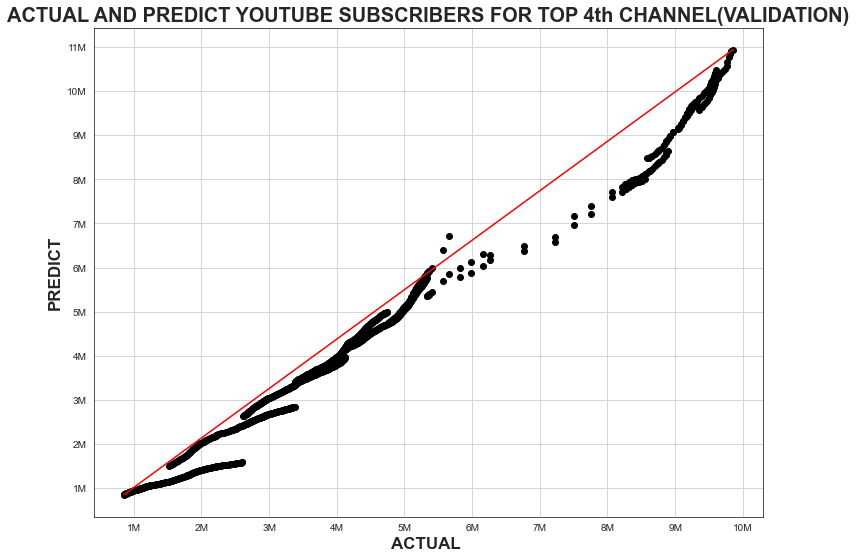

In [44]:
plt.figure(figsize = [12,9])
plt.scatter(df_cv[4].y,df_cv[4].yhat,c="black")

x_plt_range = [df_cv[4].y.min(),df_cv[4].y.max()]
y_plt_range = [df_cv[4].yhat.min(),df_cv[4].yhat.max()]
    
plt.plot(x_plt_range,y_plt_range,c="r")
    

plt.xticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 
7000000, 8000000, 9000000, 10000000],
["1M", "2M", "3M", "4M", "5M", "6M", 
"7M", "8M", "9M", "10M"])
plt.yticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 
7000000, 8000000, 9000000, 10000000,11000000],
["1M", "2M", "3M", "4M", "5M", "6M", 
"7M", "8M", "9M", "10M","11M"])



plt.grid()
sns.set_style("white")
plt.xlabel("ACTUAL ",fontsize = 17, weight = 'bold')
plt.ylabel('PREDICT',fontsize = 17, weight = 'bold')
plt.title("ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS FOR TOP 4th CHANNEL(VALIDATION)",fontsize = 20, weight = 'bold')

## Training Plots

0.9988099531430792
0.9993020658826712
0.9997152326201524
0.9998381585233426
0.9990724132413185


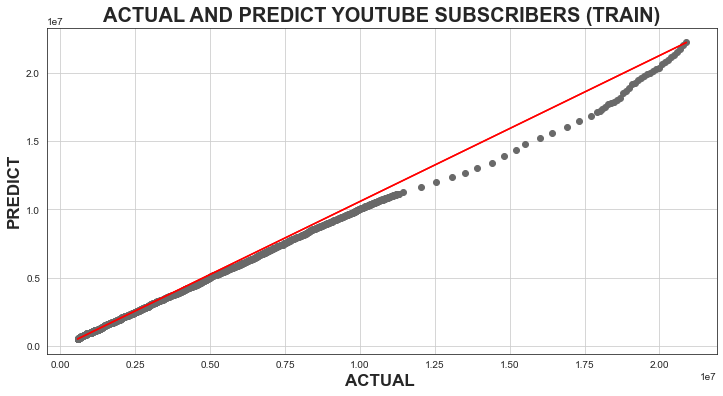

<Figure size 432x288 with 0 Axes>

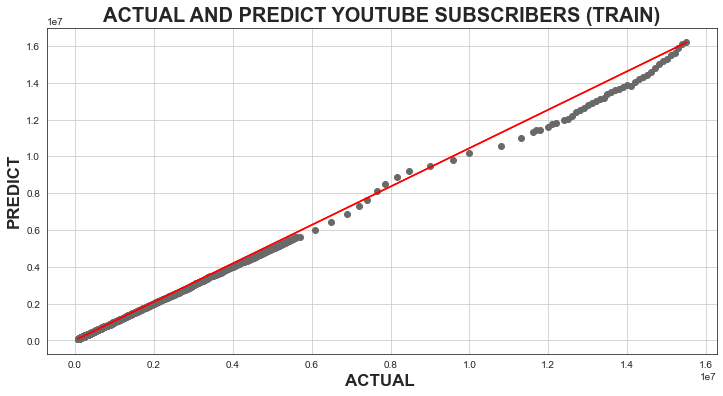

<Figure size 432x288 with 0 Axes>

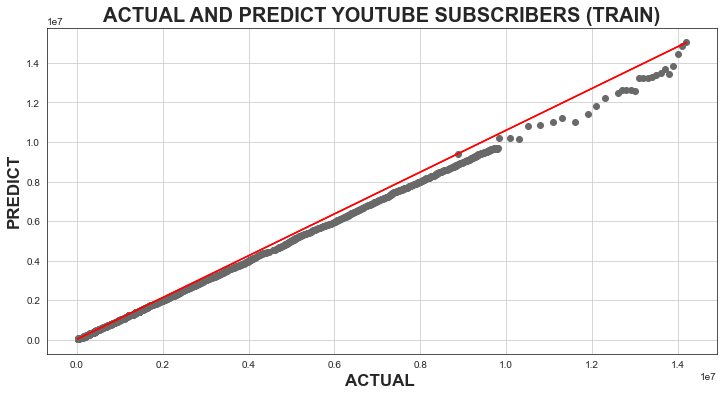

<Figure size 432x288 with 0 Axes>

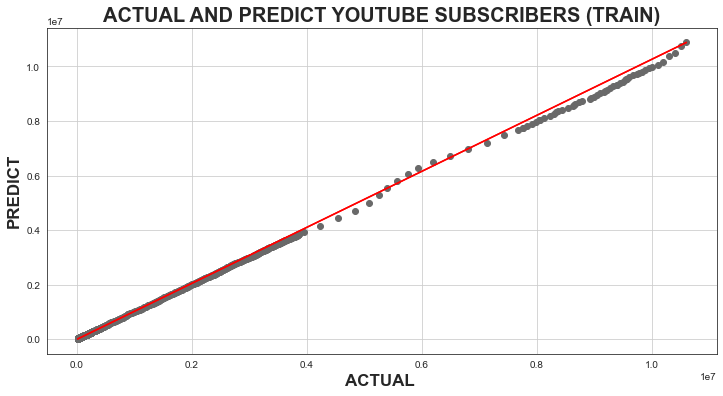

<Figure size 432x288 with 0 Axes>

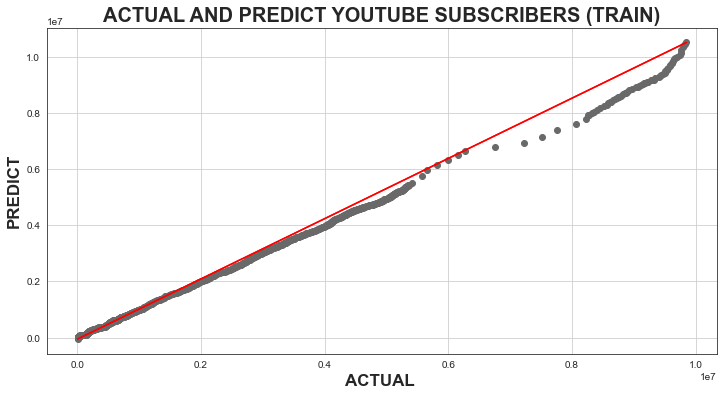

<Figure size 432x288 with 0 Axes>

In [45]:
for y_yhat in ys_yhats:
    print(r2_score(y_yhat["y"],y_yhat["yhat"]))
    plt.figure(figsize = [12,6])
    plt.scatter(y_yhat["y"],y_yhat["yhat"],c="dimgray")
    
    sns.set_style("white")
    plt.grid()
    x_plt_range = [y_yhat["y"].min(),y_yhat["y"].max()]
    y_plt_range = [y_yhat["yhat"].min(),y_yhat["yhat"].max()]
    plt.plot(x_plt_range,y_plt_range,c="r")
    plt.title("ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS (TRAIN)",fontsize = 20, weight = 'bold')
    plt.xlabel("ACTUAL ",fontsize = 17, weight = 'bold')
    plt.ylabel('PREDICT',fontsize = 17, weight = 'bold')
    plt.plot(x_plt_range,y_plt_range,c="r")
    plt.figure()
    

Text(0.5, 1.0, 'ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS FOR TOP 4th CHANNEL(TRAIN)')

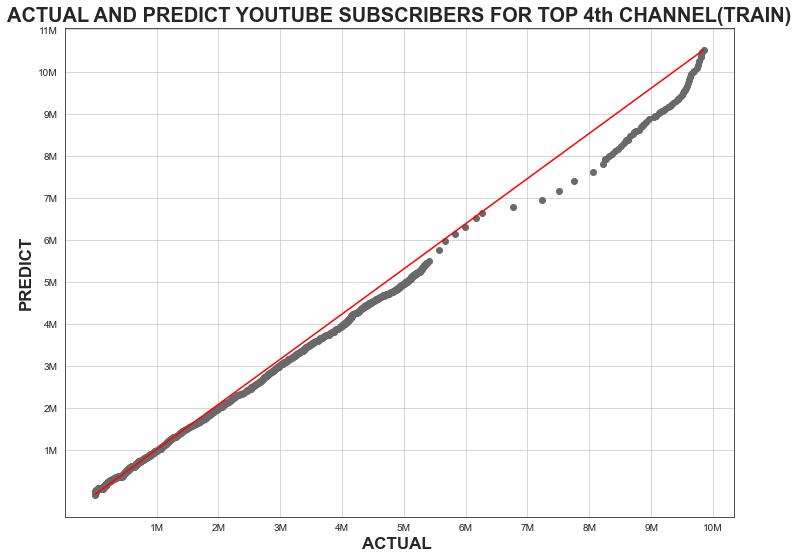

In [46]:
plt.figure(figsize = [12,9])
plt.scatter(y_yhat["y"],y_yhat["yhat"],c="dimgray")
x_plt_range = [y_yhat["y"].min(),y_yhat["y"].max()]
y_plt_range = [y_yhat["yhat"].min(),y_yhat["yhat"].max()]
plt.plot(x_plt_range,y_plt_range,c="r")

plt.xticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 
7000000, 8000000, 9000000, 10000000],
["1M", "2M", "3M", "4M", "5M", "6M", 
"7M", "8M", "9M", "10M"])
plt.yticks([1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 
7000000, 8000000, 9000000, 10000000,11000000],
["1M", "2M", "3M", "4M", "5M", "6M", 
"7M", "8M", "9M", "10M","11M"])

plt.grid()
sns.set_style("white")
plt.xlabel("ACTUAL ",fontsize = 17, weight = 'bold')
plt.ylabel('PREDICT',fontsize = 17, weight = 'bold')
plt.title("ACTUAL AND PREDICT YOUTUBE SUBSCRIBERS FOR TOP 4th CHANNEL(TRAIN)",fontsize = 20, weight = 'bold')

In [ ]:
# tss = TimeSeriesSplit()
# for tarin,val in tss.split(X_y):
md = Prophet()
md.fit(X_y)

In [ ]:
# for train,val in kf:
#     print("train Range:",min(train),max(train),"val Range:",min(val),max(val))
X_y.ds

In [ ]:
df_cv = cross_validation(md,initial='730 days', period='100 days', horizon = '200 days')

In [ ]:
df_cv

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(df_cv.y,df_cv.yhat)
plt.plot([0.7e7,2.2e7],[0.7e7,2.2e7],c="r")

In [ ]:
r2_score(df_cv.y,df_cv.yhat)

In [ ]:
df_p = performance_metrics(df_cv)
df_p

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [ ]:
future = md.make_future_dataframe(periods=365)

In [ ]:
future

In [ ]:
forecast = md.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
 md.plot_components(forecast)

In [ ]:
y_yhat = top1_m.merge(forecast[["ds","yhat"]],left_on="Date",right_on="ds")
r2_score(y_yhat["TotalVideoViews"],y_yhat["yhat"])

In [ ]:
r2_score()

In [ ]:
df1[(df1["Weekly Subscribers Gained"] == 100000)]

# needs to check it 


In [ ]:
with open('req0.html') as page:
    html = page.read()
soup = BeautifulSoup(html, 'lxml')

In [ ]:
#print(soup.prettify())

In [ ]:
# up_string = soup.find_all(text=re.compile('Up'))
# up_string

In [ ]:
# rows = [row for row in soup.find_all("span",class_="YouTubeUserTopLight")]
# rows

In [ ]:
# soup.find_all("span",class_="YouTubeUserTopLight")[0].text

In [ ]:
# rows = [row for row in soup.find_all("span",style="font-weight: bold;")] 
# rows[0:6]

In [ ]:
list_columns=[]
for i in soup.find_all("span",class_="YouTubeUserTopLight"):
        list_columns.append(i.get_text())
print(list_columns)

In [ ]:
list_req0=[]
for i in soup.find_all("span",style="font-weight: bold;"):
        list_req0.append(i.get_text())
print(list_req0)

In [74]:
from statsmodels.tsa.arima.model import ARIMA